# mini hw3 - ensembles

## Подготовка данных

Загрузите и предобработайте данные (по своему усмотрению) из hw1

In [17]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder 

from sklearn.model_selection import train_test_split
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import ShuffleSplit, KFold, GroupKFold, StratifiedKFold
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.ensemble import RandomForestClassifier

import torch
from torch import nn
import torch.nn.functional as F
import math

pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings('ignore')

In [18]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(20)

In [19]:
def divide_df(df):
    dct = {'M': 1, 'F': 0, 'D': 2, 'C': 3, 'B': 4, 'A': 5}
    df['sex'] = df['sex'].map(dct)

    df_wrong = df[(df['age'] > 22) | (df['age'] < 15) | ((df['sex'] != 1) & (df['sex'] != 0)) | (df.isnull().any(1))]
    df_wrong['address'] = df_wrong['address'].astype('category').cat.codes
    
    df_right = df[~((df['age']>22) | (df['age'] < 15) | ((df['sex'] != 1) & (df['sex'] != 0)) | (df.isnull().any(1)))]
    df_right['address'] = df_right['address'].astype('category').cat.codes
    return df_wrong, df_right

def divide_df_wrong(df_wrong, feat):
    if feat == 'sex':
        df_wrong_c = df_wrong[(df_wrong['sex'] != 0) & (df_wrong['sex'] != 1)]
    elif feat == 'age':
        df_wrong_c = df_wrong[(df_wrong['age'] > 22) | (df_wrong['age'] < 15) | (df_wrong['age'].isna())]
    elif feat == 'address':
        df_wrong_c = df_wrong[(df_wrong['address'] != 0) & (df_wrong['address'] != 1)]
    return df_wrong_c

def repair_df(algorythm, df_wrong, df_right, feats):
    for feat in feats:
        X = df_right.drop([feat],axis = 1)
        y = df_right[feat]
        algorythm.fit(X, y)
        X_pred = divide_df_wrong(df_wrong, feat)
        X_pred[feat] = algorythm.predict(X_pred[X.columns])
        df_wrong[feat].update(X_pred[feat])

In [20]:
from sklearn.preprocessing import LabelEncoder

In [21]:
data = pd.read_csv('train_features_with_answers.csv')

cols = data.columns
labelencoder = LabelEncoder()

num_cols = data._get_numeric_data().columns
for i in list(set(cols) - set(num_cols)):
    if i != 'sex' and i != 'age' and i != 'address':
        data[i] = labelencoder.fit_transform(data[i].values)

df = data.copy() 
df_wrong, df_right = divide_df(df)
repair_df(KNeighborsClassifier(), df_wrong, df_right, ['sex', 'age', 'address'])
df = pd.concat([df_wrong, df_right]).sort_index()


In [22]:
target = 'G3'
y = df[target]
X = df.drop(target, axis = 1)

In [23]:
df  

school  sex   age  address  famsize  Pstatus  Medu  Fedu  Mjob  Fjob  \
0         1    1  18.0        1        1        1     1     3     0     3   
1         0    1  17.0        0        1        1     3     3     4     2   
2         0    1  15.0        1        0        1     3     4     2     2   
3         1    1  17.0        0        0        1     4     3     3     2   
4         0    0  20.0        0        0        1     2     1     2     2   
..      ...  ...   ...      ...      ...      ...   ...   ...   ...   ...   
449       0    1  15.0        1        0        1     4     2     2     2   
450       0    0  15.0        1        0        1     2     2     2     2   
451       0    1  16.0        1        0        1     4     4     3     3   
452       1    0  15.0        0        1        1     1     1     0     3   
453       0    1  15.0        1        0        1     4     4     3     2   

     ...  internet  romantic  famrel  freetime  goout  Dalc  Walc  health  \
0    ...         1         1       4         3      3     2     3       3   
1    ...         1         0       3         3      4     3     5       3   
2    ...         1         0       5         5      1     1     1       5   
3    ...         1         1       4         5      5     1     3       2   
4    ...         1         1       1         2      3     1     2       2   
..   ...       ...       ...     ...       ...    ...   ...   ...     ...   
449  ...         1         0       3         3      3     1     1       3   
450  ...         1         0       5         1      2     1     1       3   
451  ...         1         0       5         3      2     1     2       5   
452  ...         1         0       5         4      3     1     2       4   
453  ...         1         0       5         3      3     1     1       5   

     absences  G3  
0           0   9  
1          16  12  
2           0  13  
3           4  11  
4           8  12  
..        ...  ..  
449         0  10  
450         4  10  
451         4  15  
452         0  10  
453         2  12  

[454 rows x 31 columns]

## Обоснуйте выбор слабых (базовых) алгоритмов

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error as mae

## Постройте решение на основе подхода Blending

Правила:
- Нужно использовать вероятности 
- Предложите что-то лучше, чем брать среднее от предсказаний моделей (оценивать уверенность алгоритмов, точности и т.д.)
- Заставьте базовые алгоритмы быть некорелированными
- Добавьте рандома (например, стройте ваши алгоритмы на разных выборках, по разному предобрабатывайте данные или применяйте для разных признаков соответствующие алгоритмы ... )
- Проявите смекалку

In [37]:
#try use seed
def blending(classifiers, X, y):
    df_ans_train = pd.DataFrame()
    df_ans_test = pd.DataFrame()
    
    y_train, y_train_alg  = None, None
    
    while y_train is None or len(np.unique(y_train))!=len(np.unique(y)):
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=21)
        
    while y_train_alg is None or len(np.unique(y_train_alg))!=len(np.unique(y)):
        x_train_alg, x_train_w, y_train_alg, y_train_w = train_test_split(x_train, y_train, test_size=0.3, shuffle=True, random_state=56)
    
    for clf in classifiers:
        clf.fit(x_train_alg, y_train_alg)

        df_ans_train = pd.concat([df_ans_train, pd.DataFrame(clf.predict_proba(x_train_w))], axis=1)
        df_ans_test = pd.concat([df_ans_test, pd.DataFrame(clf.predict_proba(x_test))], axis=1)
        
        print(f'{str(clf)[:-2]} = {accuracy_score(clf.predict(x_test), y_test)}')
    
#     lr = LogisticRegression(solver='lbfgs', multi_class='ovr')
#     lr.fit(df_ans_train, y_train_w)

    #sv = SVC(kernel='rbf', C=1, max_iter=100, probability=True)
    #sv.fit(df_ans_train, y_train_w)
    
    rf = RandomForestClassifier(max_samples=100, bootstrap=True)
    rf.fit(df_ans_train, y_train_w)
    
    print(f'overall score = {accuracy_score(rf.predict(df_ans_test), y_test)}')


In [38]:
seed_everything(20)
sklearn_nb = naive_bayes.GaussianNB()
sklearn_knn = KNeighborsClassifier(50)
sklearn_lс = LogisticRegression()
sklearn_tree = DecisionTreeClassifier()
sklearn_svc = SVC(kernel='poly', C=1, max_iter=100, probability=True)

d = [sklearn_nb, sklearn_knn, sklearn_lс, sklearn_tree, sklearn_svc]
blending(d, X, y)

GaussianNB = 0.07692307692307693
KNeighborsClassifier(n_neighbors=5 = 0.17582417582417584
LogisticRegression = 0.15384615384615385
DecisionTreeClassifier = 0.14285714285714285
SVC(C=1, kernel='poly', max_iter=100, probability=Tru = 0.18681318681318682
overall score = 0.2087912087912088


## Постройте решение на основе подхода Stacking

Правила:
- Реализуйте пайплайн обучения и предсказания (например, sklearn.pipeline или класс)
- Проведите оптимизацию пайплайна
- Оцените вклад каждого базового алгоритма в итоговое предсказание

In [30]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=21)

In [31]:
x_train = x_train.reset_index()
x_train = x_train.drop(['index'], axis=1)

In [32]:
y_train = y_train.reset_index()
y_train = y_train.drop(['index'], axis=1)

In [33]:
kf = KFold(n_splits = 5)

In [34]:
for train_index, test_index in kf.split(x_train):
    #print("TRAIN:", train_index, "TEST:", test_index)
    x_train_1, x_test_1 = x_train.loc[train_index], x_train.loc[test_index]
    y_train_1, y_test_1 = y_train.loc[train_index], y_train.loc[test_index]
x_train_1

school  sex   age  address  famsize  Pstatus  Medu  Fedu  Mjob  Fjob  \
0         1    0  18.0        0        0        0     4     3     3     3   
1         1    0  16.0        0        0        0     2     2     1     2   
2         0    1  20.0        1        0        0     3     2     3     2   
3         0    0  18.0        1        0        1     3     3     3     3   
4         0    1  17.0        0        0        1     1     1     2     2   
..      ...  ...   ...      ...      ...      ...   ...   ...   ...   ...   
286       0    0  17.0        0        0        1     2     4     0     2   
287       1    1  19.0        1        0        1     1     1     2     2   
288       0    1  17.0        1        0        1     2     2     2     2   
289       0    0  15.0        1        0        1     1     1     2     2   
290       1    1  17.0        1        1        1     3     1     3     3   

     ...  higher  internet  romantic  famrel  freetime  goout  Dalc  Walc  \
0    ...       1         1         0       5         4      4     3     4   
1    ...       1         0         1       3         3      2     1     1   
2    ...       1         0         0       5         5      3     1     1   
3    ...       1         1         0       5         3      4     1     1   
4    ...       1         1         1       4         3      3     1     1   
..   ...     ...       ...       ...     ...       ...    ...   ...   ...   
286  ...       1         1         1       4         4      3     1     1   
287  ...       0         1         0       4         4      3     3     4   
288  ...       0         1         0       4         4      4     2     3   
289  ...       1         1         0       4         3      2     2     3   
290  ...       1         1         0       2         4      5     3     4   

     health  absences  
0         2         8  
1         3         2  
2         5         0  
3         4         8  
4         1         2  
..      ...       ...  
286       5         0  
287       4         2  
288       4         8  
289       4         2  
290       2         6  

[291 rows x 30 columns]

In [222]:
meta = pd.DataFrame()
meta = meta.append([1,5,6], ignore_index=True)
meta = meta.append([4,5,7],  ignore_index=True) 
meta 

0
0  1
1  5
2  6
3  4
4  5
5  7

In [233]:
meta = np.array([], dtype = 'int64')
meta = np.concatenate((meta, [4, 6, 7]))
meta 

array([4, 6, 7], dtype=int64)

In [35]:
def stacking(classifiers, X, y, n_folds = 3):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=21)
    
    df_ans_train = pd.DataFrame()
    df_ans_test = pd.DataFrame()
    df_best_cls = {}
    scores = {}
    
    for clf in classifiers:
        clf_name = str(clf)[:-2]
        meta_feat = cross_val_predict(clf, x_train, y_train, cv=n_folds)
        df_ans_train[clf_name] = meta_feat

        cr_v = cross_validate(clf, x_train, y_train, cv = n_folds, return_estimator = 1)
        df_best_cls[clf_name] = cr_v['estimator'][np.argmax(cr_v['test_score'])]
        
        df_ans_test[clf_name] = df_best_cls[clf_name].predict(x_test)
        scores[clf_name] = accuracy_score(df_ans_test[clf_name], y_test)
        print(f'{str(clf)} score = {scores[clf_name]}','\n')

    w_sum = sum(scores.values())
    scores_propor = {cls: w / w_sum  for cls, w in scores.items()}
    
    sns.barplot(y=list(scores_propor.keys()), x = list(scores_propor.values()), palette="rocket")
    plt.xticks(rotation=0)
    plt.title('proportion of algorithms', fontsize=16);
    
    lr = LogisticRegression(solver='lbfgs', multi_class='ovr')
    lr.fit(df_ans_train, y_train)
    
    f = plt.figure(figsize=(10, 9))
    plt.matshow(df_ans_train.corr(), fignum=f.number)
    plt.xticks(range(df_ans_train.select_dtypes(['number']).shape[1]), df_ans_train.select_dtypes(['number']).columns, fontsize=14, rotation=90)
    plt.yticks(range(df_ans_train.select_dtypes(['number']).shape[1]), df_ans_train.select_dtypes(['number']).columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16);
    
    print(f'overall score = {accuracy_score(lr.predict(df_ans_test), y_test)}')

GaussianNB() score = 0.07692307692307693 

KNeighborsClassifier(n_neighbors=50) score = 0.16483516483516483 

LogisticRegression() score = 0.17582417582417584 

DecisionTreeClassifier() score = 0.10989010989010989 

SVC(C=1, kernel='poly', max_iter=100, probability=True) score = 0.16483516483516483 

overall score = 0.21978021978021978


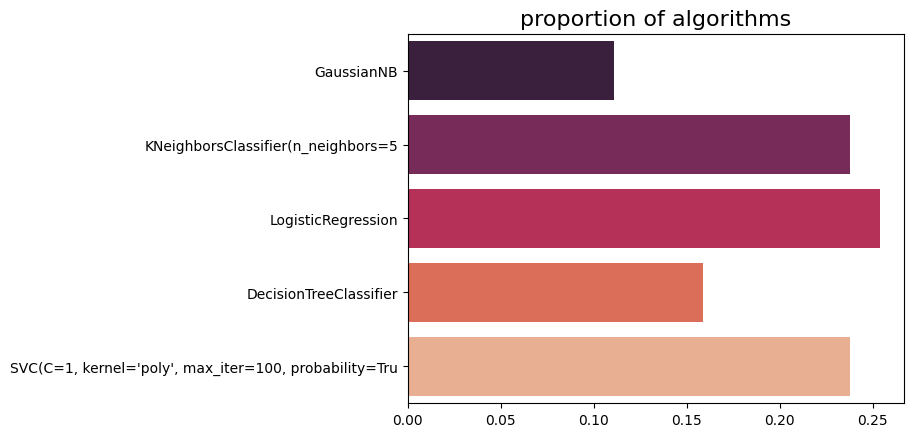

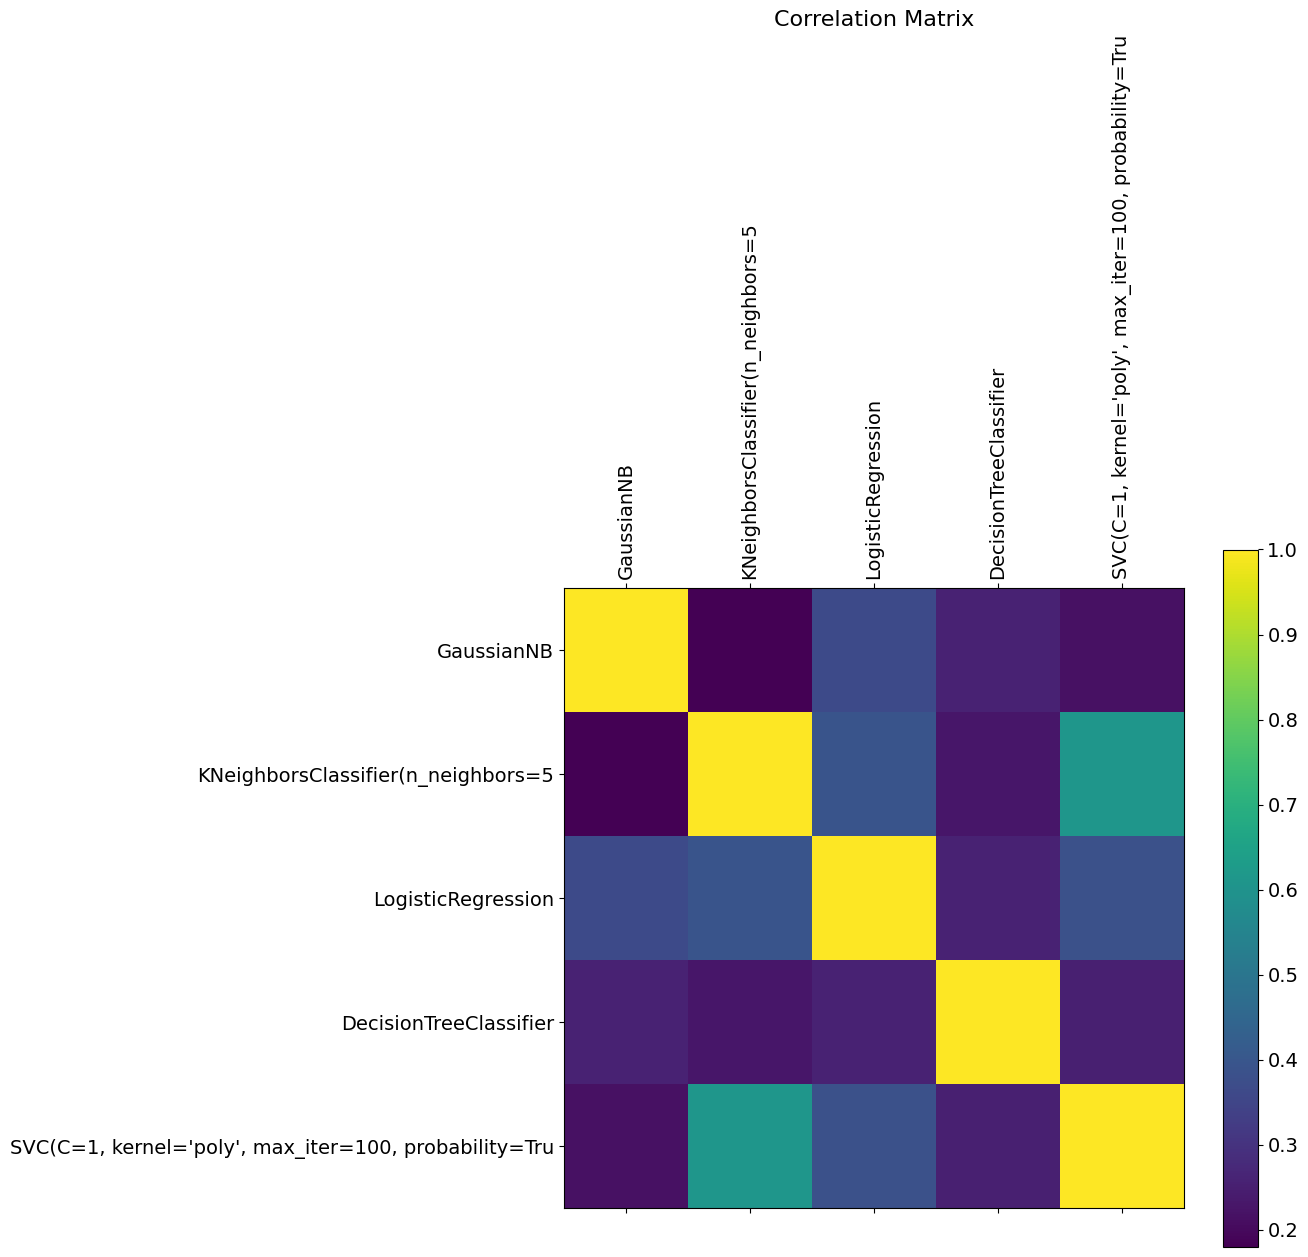

In [36]:
stacking(d, X, y)

In [381]:
X.shape[1] 

54

In [252]:
def stacking_opt(classifiers, X, y, n_folds = 3):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=21)
    # create a network that stacks layers on top of each other
    
    df_ans_train = pd.DataFrame(index = x_train.index)
    df_ans_test = pd.DataFrame()
    df_best_cls = {}
    scores = {}
    
    for clf in classifiers:
        clf_name = str(clf)[:-2]
        meta_feat = cross_val_predict(clf, x_train, y_train, cv =  n_folds)
        df_ans_train[clf_name] = meta_feat

        cr_v = cross_validate(clf, x_train, y_train, cv = n_folds, return_estimator = 1)
        df_best_cls[clf_name] = cr_v['estimator'][np.argmax(cr_v['test_score'])]
        
        df_ans_test[clf_name] = df_best_cls[clf_name].predict(x_test)
        scores[clf_name] = accuracy_score(df_ans_test[clf_name], y_test)
        print(f'{str(clf)} score = {scores[clf_name]}','\n')
    
    #scores_propor = {cls: 1 / w for cls, w in scores.items()}
    w_sum = sum(scores.values())
    scores_propor = {cls: w / w_sum  for cls, w in scores.items()}
    
    model = nn.Sequential()

    model.add_module('l1', nn.Linear(df_ans_train.shape[1], y.shape[0]))

    # note: layer names must be unique
    model.add_module('l2', nn.Softmax())
    
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    history = []
    for i in range(1000):
        ix = (df_ans_train.sample(frac = 0.85).index)
        x_batch = torch.tensor(df_ans_train.loc[ix].values, dtype=torch.float32)
        print(y_train.loc[ix].values)
        y_batch = torch.tensor(y_train.loc[ix].values, dtype=torch.float32)
        
        y_predicted = model(x_batch)[:, 0]
        print(y_predicted, y_batch)
        loss = F.cross_entropy(y_predicted, y_batch)

        loss.backward()
        opt.step()
        opt.zero_grad()

        history.append(loss.data.numpy())

        if i % 1000 == 0:
            print("step #%i | mean loss = %.3f" % (i, np.mean(history[-10:])))
    stacking_pred_proba = model(torch.tensor(df_ans_test.values, dtype=torch.float32))
    stacking_pred = np.array(stacking_pred_proba.detach().numpy(), dtype=np.int)
    print(stacking_pred_proba, stacking_pred_proba.shape, stacking_pred_proba.max())
    print(f'overall score = {accuracy_score(stacking_pred, y_test)}')

In [253]:
stacking_opt(d, X.copy(), y.copy())

GaussianNB() score = 0.07692307692307693 

KNeighborsClassifier(n_neighbors=50) score = 0.16483516483516483 

LogisticRegression() score = 0.17582417582417584 

DecisionTreeClassifier() score = 0.0989010989010989 

SVC(C=1, kernel='poly', max_iter=100, probability=True) score = 0.16483516483516483 

[11 15 13 11 16 13 17 11 15 11 14 12 14 13 14 15 15 13 11 13 10 17  9 13
  9 14 15 10 10 12 13 10 11 12 11 10 17 17  8 14 11 13 13 14 12  9 12 13
 17 11  9 11 15 12 13  9 13  9 12 12 17  9  5 15 13 15 14 13 13 12 11 13
  9 11 12 10 13 10 10  7 13 10 10  8 10 17 14 12 11 14 13  8 12 16 14 11
 14 13 12  1 15 17 10 12 15 13 15 15 11 10 16 10 11 17 12 15 13 11 13 10
 11 16 10  8  7 13 14 10 14 10 11  8  6 15 10 16 14 12 10  9  8 17 11 12
 13 17 16 13 11 15 12 13 13 13 17 12  0 16 12  9 14 11 14 16 14 11 11  8
 13 12  9 11  0 13 11  8 10 13 10 15 10 16 15 14  8  8 14 16 14 15 17 16
  9 12 11 12 13 15  9 17 10 19 11 11 16 15 13  9 16 18 10 11 13  9 10 12
  0 11 16 15 14 12 13  9 10 12 11 10 11 13

        4.0475e-14, 8.0169e-14, 3.7408e-14], grad_fn=<SelectBackward0>) tensor([16., 13.,  8., 15., 10., 10.,  6., 15., 16., 10., 17., 15., 13., 10.,
        15., 10., 13., 12., 13., 14., 15.,  9.,  8., 10., 15., 13., 18.,  8.,
        17., 12., 11., 11., 14., 17., 10., 10.,  8., 14., 15., 11., 14., 18.,
        15., 10.,  5., 11., 13.,  8., 12.,  8., 18., 10., 11., 17., 10., 11.,
        14.,  7.,  9., 13., 10.,  9., 12.,  9., 14., 12., 13., 15., 10., 10.,
        17., 14., 14., 13.,  9., 13., 13., 12.,  9., 11., 12., 15., 10., 10.,
        10., 12., 10., 16., 11., 14.,  8., 17., 13., 13., 11., 12., 10.,  8.,
        10.,  9., 12., 11., 16., 11., 13.,  8., 15.,  6., 17., 10., 11., 11.,
        17., 17., 17., 13., 13.,  9., 11., 13., 12., 11., 14.,  8., 11., 10.,
        11., 10., 10., 11., 11.,  8., 12., 13.,  0., 11., 11., 10., 14., 14.,
        16., 18., 10., 14., 11., 12., 13., 13., 12., 17., 13., 12., 13., 11.,
        13., 13., 11., 12., 16., 13., 10.,  8., 16., 13., 16., 15., 11

tensor([1.3534e-15, 3.7031e-15, 8.1174e-13, 8.3532e-14, 9.0073e-17, 7.8506e-16,
        1.0336e-15, 1.0628e-16, 2.1390e-14, 5.8173e-14, 1.8172e-15, 2.0300e-10,
        1.1295e-13, 3.7527e-15, 3.9479e-16, 1.0336e-15, 2.0189e-15, 1.4444e-16,
        1.0733e-16, 3.8683e-15, 7.1756e-15, 2.0395e-16, 4.6577e-15, 1.5536e-14,
        2.8811e-13, 2.2361e-16, 1.3542e-15, 9.4873e-14, 6.7672e-10, 4.8736e-14,
        1.9525e-12, 1.1105e-14, 1.6376e-11, 1.3723e-15, 3.3506e-09, 4.2891e-14,
        5.0607e-18, 3.4983e-15, 3.1098e-14, 1.5336e-10, 5.2648e-16, 1.5486e-12,
        1.2856e-14, 1.0628e-16, 3.4038e-15, 7.1294e-15, 2.6868e-14, 3.6469e-15,
        5.3714e-16, 4.5343e-11, 1.7713e-16, 3.0128e-14, 9.7244e-15, 9.8040e-16,
        9.7244e-15, 5.1473e-13, 7.7565e-12, 1.9860e-15, 2.7734e-14, 7.8833e-16,
        9.9754e-18, 1.2770e-14, 3.8112e-15, 1.1789e-13, 7.0609e-17, 1.5045e-14,
        3.5800e-12, 8.5102e-14, 6.8391e-17, 4.5782e-16, 2.6719e-12, 8.9228e-16,
        8.8526e-13, 1.4623e-17, 3.7419e-

        2.2008e-13, 1.8049e-12, 1.8617e-15], grad_fn=<SelectBackward0>) tensor([10., 10., 15., 13., 10.,  9., 11., 13., 13., 13., 10., 11., 11.,  8.,
        11., 11.,  9., 15., 14., 10., 13., 14.,  9., 18.,  8.,  9.,  9., 14.,
         8.,  7., 12., 10., 15., 13., 11., 12., 11., 17., 11., 10., 11., 16.,
        13., 10., 15., 11., 10.,  7., 11., 10., 11., 15., 13., 16., 14., 12.,
        10., 17., 12., 14., 16., 10.,  9., 10., 11., 13.,  9., 13., 13., 16.,
        12., 17., 14.,  8.,  8., 16., 10., 13.,  8., 13.,  0., 10., 11., 10.,
        14., 10., 15., 12., 17., 12., 11., 15., 11., 11., 11., 10., 11., 10.,
        13., 13., 10., 10.,  8., 10.,  8., 17., 13.,  9.,  0., 13., 11., 14.,
        13., 10., 10., 10., 13.,  8., 12., 11., 18., 14., 13.,  6., 16., 16.,
        16., 14., 10.,  8., 12.,  9.,  8., 17., 15., 17., 14., 10., 14.,  8.,
        12., 13., 17., 15., 18.,  5., 11., 15., 11., 14., 11., 14., 12.,  6.,
        11., 16.,  8., 14., 12., 14., 11., 15., 12., 11., 19.,  9., 15

        1.1405e-17, 1.3178e-13, 1.2706e-14], grad_fn=<SelectBackward0>) tensor([17., 17., 12., 11., 13., 12.,  9., 10., 15.,  8., 10., 14.,  8., 12.,
        15., 11., 14., 11.,  0.,  9., 15., 11., 17., 14., 10., 10., 13.,  6.,
        10., 11., 10., 10., 15., 12., 13.,  8., 13., 12.,  7., 13., 12.,  8.,
         9.,  8., 14., 11.,  8., 13., 14., 13., 15., 15., 10., 10.,  9., 15.,
        17., 13., 15.,  9., 14., 14., 13., 14., 16.,  9.,  9.,  1., 16., 16.,
        13., 18., 10., 10., 11., 17., 15., 11.,  9., 17., 10., 12., 14., 14.,
        17., 10.,  9., 12., 16., 11., 15., 10.,  8., 13., 14., 13., 13., 12.,
        12., 14., 19., 13., 15.,  0.,  8., 11., 17., 14., 14., 12., 13., 16.,
        10., 11., 11., 11., 10., 13., 17., 11.,  0.,  0.,  8., 17., 10., 11.,
         9., 11., 12., 12., 12., 18., 13., 14., 11., 12., 13., 13., 16., 14.,
        15., 14., 13., 13.,  8., 16., 12., 15., 12., 10., 11.,  9., 10., 11.,
        15.,  9., 10., 13., 13., 11., 10.,  5.,  8., 14., 11., 10., 16

        1.3751e-13, 3.8543e-16, 4.2247e-14], grad_fn=<SelectBackward0>) tensor([13., 10., 17.,  8., 14., 10.,  9., 11., 16., 17., 14., 13., 14., 11.,
        13., 10., 11., 11., 13.,  9., 11., 14.,  9., 15., 10.,  9., 12.,  0.,
        13., 11., 13., 10., 16., 13., 16., 17., 11., 10.,  6., 10.,  9., 15.,
         9., 12., 14., 15., 14., 17., 10., 13., 11., 17., 10., 10., 15., 12.,
        11., 10., 13., 14.,  9., 12., 13., 11., 11., 14.,  9., 13., 19., 16.,
         0., 12., 15., 14., 10.,  8., 15., 16., 12., 11.,  6., 18., 14.,  8.,
        14., 11., 12., 17., 13., 13.,  5., 13., 13., 14., 15., 14., 13., 13.,
        10., 15., 16.,  9., 10., 13., 14., 11.,  8., 14., 10., 17., 12.,  8.,
        10., 10., 12., 17., 11., 15., 16., 14., 17., 11.,  9.,  8., 14., 15.,
        12.,  9., 10., 14., 12., 14.,  9.,  9., 13., 10., 11., 10., 13., 11.,
         8., 11., 14.,  8., 11., 10., 14., 11., 10.,  8.,  1., 17., 16., 10.,
        10., 11.,  8.,  8., 14., 11.,  7., 13., 15., 11., 11., 14., 13

        1.1006e-16, 2.5089e-19, 4.5211e-16], grad_fn=<SelectBackward0>) tensor([10., 13., 14.,  8., 15., 15.,  9., 13., 17., 10., 11., 15., 15., 10.,
         8., 10., 12.,  7., 17.,  9., 13., 10., 14., 16., 15., 12., 11., 11.,
         9.,  8., 11., 14., 11., 14., 13., 10.,  0., 11., 16., 12.,  8., 14.,
        14., 17., 19., 14., 11.,  8., 15., 12., 10., 10.,  0., 12., 13., 13.,
        13., 10., 12., 10., 10., 15., 11.,  7., 12., 11., 17., 10., 13., 13.,
        11., 12., 11., 11., 11., 10.,  9., 15.,  6., 11., 13., 12., 15., 13.,
        13., 14.,  7., 10., 12., 14., 10.,  8., 11.,  8., 11., 13., 13., 12.,
        15., 17., 13., 13., 11., 18., 10.,  9., 11., 13., 12.,  8., 12., 11.,
        13., 16., 11., 14., 13., 16., 14., 10., 14., 13., 11., 13.,  9., 14.,
         9., 16., 12., 13., 12., 16., 12.,  8., 13., 10., 10.,  5., 17., 12.,
        10., 17., 10., 10., 10., 11., 16., 13., 14., 17., 11., 11., 12., 12.,
         9., 16.,  8., 12., 10.,  8., 12., 10., 12., 14., 12., 16., 11

        1.1162e-14, 7.4501e-13, 5.2517e-15], grad_fn=<SelectBackward0>) tensor([13., 16., 11., 11., 15.,  0., 13., 13.,  9., 13., 11., 15., 13., 13.,
         8., 16., 14.,  8., 14., 14.,  7., 17., 10., 11., 14., 16., 12., 10.,
        13., 10., 12., 15., 13., 11.,  9., 10., 15.,  8., 15., 14., 16., 11.,
        11., 17.,  9., 19., 15., 15., 17., 11., 13., 13.,  8., 11., 12., 10.,
        10., 11., 13., 16., 12., 16., 12.,  8., 10.,  5.,  8.,  8., 11., 10.,
        17., 10., 12., 12.,  9., 17., 12., 15., 15., 14.,  9., 14., 18., 13.,
        11., 16., 10., 14., 12., 15., 13., 11.,  9., 10., 10., 12., 11., 16.,
         8., 11., 14.,  8.,  9., 13., 12.,  7., 13., 13., 11., 10.,  9., 14.,
        17., 11., 13., 15., 16., 10., 12.,  9., 12., 13., 11., 10., 11., 12.,
        10., 12., 17., 10., 13., 11., 17.,  9., 11., 16., 13., 13., 11.,  0.,
         9.,  9., 18., 12., 14., 10., 17., 11., 11.,  9., 11., 10., 12., 11.,
        11., 10., 15., 14., 14., 15., 11., 11.,  9., 11., 13., 13., 17

        4.5290e-15, 2.0783e-15, 7.7261e-13], grad_fn=<SelectBackward0>) tensor([14.,  9., 11., 10.,  8., 10.,  0.,  8., 14., 10.,  0., 10., 13., 12.,
        15., 15., 12., 10., 14.,  8., 14., 10.,  5., 17.,  8., 11., 14.,  9.,
        16., 14., 11.,  7., 16., 14., 13.,  9., 19., 13., 11., 18., 14., 11.,
         0., 12., 15., 10., 13., 11., 10., 11., 10., 13., 12.,  6., 15., 16.,
        15., 15.,  8.,  8., 11., 11., 13.,  9.,  1., 12., 10., 17.,  8.,  9.,
        16., 15., 16., 15., 17., 13., 14.,  8., 13., 13.,  8., 14., 17., 11.,
        11., 16., 11.,  0., 12., 13., 16., 12., 11., 14., 17., 12., 12., 13.,
        11., 11.,  0., 16., 18., 10., 10., 16., 10., 13.,  8., 15., 13.,  9.,
         8., 13., 10., 11.,  8., 11., 14., 10., 15.,  9., 12., 11., 10., 11.,
         6., 15., 12., 13., 15., 10., 11., 13.,  8., 11., 14., 10., 13., 11.,
        16., 10., 12., 12., 11., 11., 13.,  9., 11.,  8., 15., 12., 11., 11.,
         9., 14., 14., 11., 12., 16., 13., 17., 11., 11., 17., 12., 14

        1.3230e-17, 2.6210e-15, 1.3490e-17], grad_fn=<SelectBackward0>) tensor([17., 10., 13., 11., 15., 13., 14., 14., 11., 13., 11., 14., 12., 16.,
         9., 15., 10.,  9., 10.,  8.,  0., 14., 12., 16., 15., 13.,  9., 11.,
         9., 10.,  8., 17., 13., 13., 12., 11., 16., 10., 15., 15., 11., 13.,
        13., 13., 11.,  9., 10., 17., 10.,  1., 13., 15., 14., 14., 18., 15.,
        10., 15., 11.,  9., 13., 10., 13., 12., 11., 14., 14., 17., 11., 11.,
        12., 11., 10.,  0., 13.,  9., 13., 13., 12.,  8., 11., 11.,  8., 10.,
        10., 13., 13., 11., 10., 15., 14.,  8., 13., 12., 14.,  9., 17., 13.,
        16., 14., 18., 11., 15., 13.,  8., 10., 10., 11., 10., 13., 11.,  8.,
         9., 10., 10.,  8., 12., 15., 11.,  9., 14., 17., 11., 13.,  8., 10.,
        11.,  9., 13., 12., 12., 11.,  0., 18.,  8., 10., 14., 11., 16., 10.,
        10., 13., 14., 14., 12., 15., 10., 17., 10., 10., 10., 14.,  9.,  8.,
        13., 14., 10., 10., 12., 11., 12.,  8., 10., 17.,  9., 16., 12

[13 12 13 11 15 13 12  9 13 17 11  9 14 12 13 10 13 17 14 10 11 14 15 15
 13 10 14 12 17 13 13 10 13  9  9  9 15 14 12 13  8 12 11 12 12  8 17 17
 16 19 16 13 13 11  0 15 11 12 14 10 16 10  9  8 15  9 10 10 17 11 17 16
  9 18 10 15 12 10 14  8 15 14 11 10 16 11 12 11 14  7 12  9 11 10 15 12
 10 13  9 10 10  8 16 12 15  9 12  9 10 15 13 11 10  9 17  9 11 11 10 10
 13 13 15 15 13 13 10 14 15 13 14 11 12 12 15 11  8 11 16 13 10  0 10 10
  7 12 11 10 11 13 10 13 12 12 13 11 10 15 10 13 10 13 10 15 12 14 13 12
 10  9  0 12 17 14 17 11 11  9  8  6 12  8  0 13 18 11  8 13 13 11 11 15
 13 16 16 12 14 11  9  1 10 11 11 18  8 15 12 17 17  9 11 11 14 10 16 11
 13  8 13 11 10 11  8 12 15 12 11 13  8 16 13 10 17 10 13 17 13 10 12 13
 11 14  8 10 11 10 10 15  9  8 10 14 14 14 12 13 11  9 13 15 16 10 10 10
 10 12 16 11 10 18 13 12  0 11 10 11 12  8 17 13 11 14 11  8  9  9 14 18
 14  6 15 10 14 12  0 14 14  8 17 13 14 16 14  8 14  9 13 10 15]
tensor([2.0613e-15, 3.7921e-14, 5.9835e-16, 1.0148e-17, 4.0

        1.4735e-13, 1.4377e-11, 1.6538e-17], grad_fn=<SelectBackward0>) tensor([12., 13., 16., 13., 11., 14., 11., 10., 11., 13., 11., 12., 15., 13.,
        10.,  8., 12., 13., 11., 15.,  0., 15.,  8.,  9., 14., 13., 11.,  8.,
        14.,  8., 15.,  9., 15., 10., 13., 10.,  9.,  0., 10., 12., 14.,  9.,
         0., 14.,  9., 13., 14., 13., 10., 13., 11., 14., 16.,  8., 11., 12.,
        10.,  9., 16., 12., 14., 15., 18., 18.,  8., 11., 10., 10., 17., 10.,
        12., 13.,  8.,  9.,  0., 15., 13., 14., 11.,  5., 10., 11., 17., 17.,
         9., 15., 15., 12., 14., 13., 11., 11., 15.,  9., 13., 11., 16.,  1.,
        15., 17., 10., 12., 11., 12.,  8., 12., 13., 10.,  8., 14.,  0., 15.,
        10.,  0., 12., 18.,  8., 11., 11., 11., 11., 17., 14., 14., 14., 14.,
         8., 13., 10., 13.,  8., 12., 10., 16., 11., 15., 11., 10., 16., 15.,
        14., 13., 15., 10., 15., 15., 12., 12., 16.,  9., 15., 17., 11., 16.,
        11., 12., 16., 16., 13., 13.,  9., 10., 11., 14.,  0.,  8., 15

[13  8 14 10 10  9 10 18 11 10  0 10 16 12 10 10 14 15 14 15 10 11 13 11
 16 13  7 13 18  9 10 11 10 12 12 11 13 13  8 14 13 10 17 15 10 11 12 13
  9 10 10 13 12 15  8  9  9 12 10 10 13 15 15 17  5 11 12 13 10 13 11 13
  8 14  9 17 11 11 13  8  8 14 11 10 10 13 10 15  9 10  0 13 11 17 17 17
 13 11 13 13  8 14 12 11 13 10 10 12 13 10 13 13 14 11  9 18 14 11 14 11
 11 14 10 14 11 11 11 12 10 13 10 17 15 10 10 13 10 13  8  8 10 14  8 15
 13 16 15 15 12 16 11 16 12 14 10 11 12 12 17 13 14 11 14  0 11 13  9  8
 16 14  9 12  9  0 15 12 17 17 17 16 11 16  8 11 16 10 13 18 11 14 13 14
 13 11  9 14  0 12 12 13 14  9 14  9  9 14 14 15 11 11 13 11  8 14 15 14
 10  8  0 10 12  9  8 12 12 14 16 12 11 11 15 12 12 13 14 17 10 13 16 11
 14 14 10  9  8  8 11 10 13  6 17 14 15 13 11 12 13  9 17  7  8 11 13 12
  9  8 16 11 13  9 11 14 17 15 14 15 16 11 16 12 16 11 16 16 11 13 13 11
  1  9 14  0 12  0  6 10 13 11 17 15 10 14  9 14 15 12 10 11 12]
tensor([1.9191e-15, 3.4054e-15, 2.5263e-15, 5.2804e-17, 3.7

        2.2705e-15, 1.5880e-15, 3.7225e-18], grad_fn=<SelectBackward0>) tensor([ 0., 13., 15., 13., 11., 12., 13., 13., 11., 17., 10., 10., 14., 12.,
        16., 10., 10., 13., 17., 11., 12., 12., 15., 11., 12., 11., 17., 10.,
        12., 11., 10.,  8., 15., 15., 14., 11.,  9., 13., 15., 14., 13., 13.,
        11., 11., 14.,  8., 15., 14.,  9.,  9., 11., 17., 15., 13., 11., 12.,
        13., 13.,  1., 10., 12., 15., 11.,  8.,  9., 12.,  8., 11., 13., 14.,
        10.,  8.,  7., 10., 11., 11., 15.,  7., 12., 16., 13., 11., 12., 14.,
        16., 10., 11.,  9.,  9., 16., 14., 11., 17., 12., 10., 15., 12., 14.,
        16., 10., 12., 13., 18.,  0., 11.,  0.,  7., 15., 11., 14., 16., 15.,
        14.,  9., 14.,  8., 11., 10., 14., 13., 16., 11., 12., 17., 17., 12.,
        13., 15., 11., 12.,  0., 14., 13.,  9.,  9., 16., 10., 12., 13.,  9.,
        13., 10., 15., 10., 14., 11., 10., 14.,  8.,  9., 13.,  8., 17., 14.,
        11., 11.,  8.,  9.,  0., 13., 10., 16., 16.,  0., 10.,  6., 12

[11 11 13 14 12 15 12 12 17 16 14 10  9 11 11 14  8 14 13 13 11  8 11 13
 10 10 15 17  9 10 14 11 13 14 17 15  9 17 13 14 17 18 10  8  8 10  9 14
  9 16 11 10 13 15 16 13 16 10 11  0 14 14 16 16 11  5 17 10  0 13 10 11
 14 13 10 10 11 15 11 13 13 11  8 16 14 14 13 14 17 15  9 10  9 15 16  8
  6 12 14  9 16 15 13  8 14  0 13 13 11 13 13 10 12 10  7  0 14  7  9 11
 10 14 10 10 10 10 16 12  0 11  8 17  9  9  8 15 17 12 15 15 16 13 15 12
 17 14 11 13  9 12 10 13 16 12 11 10 13 17 12 11  9 11 10 17  0 15 16 11
 12 12 11 13 12  8 13 17 12 11 14 11 11  9 14 11 13  8 17  8 14 10 15 11
 11 13 10 13 15 10 10 10  7 17 10 11 12 12 11 14 12 14 10 11 16  9 18 13
 10 13  9 11 12  8 13  8 11  8 10 11  9 12 12 19 10 10 11 15 15 13 15 15
  9 14 13 17 14 10 12 11 10 14 11 13 11  0 10 14  8 14 15 14 16 14  9 15
 12 12 12 11 12 12 15 13  9 15  8 12 10 10 13 14 15 11  1 10 10 16 11 14
 13 11  8 15 11 12 10 12 13 13 18 13 15 13 11 10 16 10 11 12 10]
tensor([1.7701e-17, 2.4464e-17, 5.3834e-16, 3.0536e-16, 1.8

tensor([4.0682e-12, 2.1208e-17, 2.0274e-19, 1.7796e-16, 3.4975e-18, 2.7074e-14,
        1.4350e-14, 1.5306e-17, 1.5125e-17, 3.6914e-15, 1.0232e-15, 3.9686e-13,
        6.1795e-17, 1.1672e-15, 2.9333e-17, 3.6282e-18, 7.8986e-14, 9.7868e-18,
        7.1596e-18, 4.9655e-17, 4.8592e-15, 3.5953e-16, 4.9655e-17, 5.4009e-18,
        7.5013e-18, 8.3188e-12, 1.3235e-17, 1.0124e-14, 4.0229e-16, 1.0487e-16,
        7.7347e-18, 1.2959e-16, 1.5078e-17, 5.8681e-15, 2.1586e-19, 1.1776e-15,
        1.1477e-15, 1.5125e-17, 3.1235e-17, 1.5328e-17, 3.1053e-13, 6.4378e-17,
        3.5700e-13, 3.2615e-17, 1.3042e-15, 5.8523e-15, 5.7797e-18, 1.1201e-17,
        7.2586e-14, 2.6419e-16, 6.2809e-19, 6.4029e-17, 4.1991e-16, 5.0868e-20,
        1.0339e-17, 6.0424e-16, 9.3249e-19, 1.4896e-18, 1.2192e-16, 3.6902e-18,
        2.4826e-18, 2.2118e-17, 5.3561e-16, 4.7762e-17, 1.6427e-17, 3.1061e-19,
        5.0868e-20, 4.5516e-20, 5.7295e-14, 8.8855e-19, 3.0865e-17, 3.0865e-17,
        2.1090e-19, 1.0011e-12, 2.2930e-

        1.5317e-16, 6.4689e-18, 1.9936e-16], grad_fn=<SelectBackward0>) tensor([13., 14., 15., 10.,  9., 10., 10.,  6., 12.,  1., 13., 14., 15., 10.,
        18.,  8., 17., 13., 11.,  9., 13., 12., 17., 16., 15., 17., 17., 10.,
        11., 13., 15.,  9., 11., 13., 10.,  8., 15., 16., 11., 10., 16., 13.,
        12., 10., 11., 10., 15., 11., 11., 12., 14., 16.,  9., 11., 11.,  9.,
        10.,  9.,  9., 15., 12., 11., 11., 15., 14., 14., 13., 10., 11.,  8.,
        14., 13., 12.,  0., 13., 17.,  9., 13.,  9.,  8., 12., 13., 17.,  9.,
        13., 13., 16., 10., 11., 15., 17., 11.,  9., 10.,  9., 15.,  0., 14.,
        13., 13., 13., 15., 13., 14.,  8., 14.,  0., 11., 15., 13., 18., 14.,
        10., 13., 16., 11.,  6., 13., 14., 16., 13., 11., 13., 11., 16., 12.,
         8., 17., 15., 11., 15., 17.,  9., 16., 10., 10.,  8., 12.,  9., 11.,
         8., 10., 12.,  0., 10., 11., 12., 10., 10., 13., 15.,  8., 10., 14.,
        13., 15.,  9., 11., 12., 12., 10., 14., 13., 15., 10.,  9., 17

        1.7165e-15, 5.5881e-18, 1.3501e-10], grad_fn=<SelectBackward0>) tensor([16., 10.,  9., 14., 11., 10., 13., 13.,  9., 12., 11., 13., 11., 14.,
        16., 11., 16., 13., 15., 10., 13.,  9.,  9., 11.,  6., 13., 17., 15.,
        13., 12., 10., 15., 12., 11., 15., 10.,  9., 10., 13., 11., 10., 14.,
        11.,  8., 13., 13., 10., 10., 14., 10., 18., 11.,  7., 12., 11., 13.,
        14., 17., 12., 11., 16., 10., 14., 17., 13., 13., 12., 17., 10., 11.,
        17., 13., 14., 13., 11., 10., 10., 11., 11., 10., 12., 13., 10.,  0.,
        14., 11., 15., 12., 15.,  8., 17.,  8., 16., 13.,  8., 12., 11., 18.,
        11., 14., 13., 11., 12.,  8., 17.,  8.,  9., 13., 11., 11., 11., 12.,
         8., 11., 11., 10., 17., 12., 12., 10., 11., 16., 17., 14.,  9., 12.,
        14., 15., 11., 10., 11., 10., 11., 11.,  9., 16., 13.,  8., 17., 18.,
        15., 17., 13., 15., 10.,  9., 11., 13.,  8., 15., 11., 10.,  8., 12.,
        15.,  8., 17., 14., 10., 13., 15., 10., 11., 12.,  6., 14.,  0

[13 11 13  9 16 11 10 17 13 11 10 14 10 14 11 12 13 16 10 13  8 12  9 13
 14 12 11 16 15 11 14 10 10 10 10 16 19 12 13 11 11 11 14 14 15 15  9 14
 12 13 13 13 13 13 17 13 13 10  9 16 14 14 13 14 12 13  9 13  9 16 13 11
 13 15 15 12  8 11 12 11 16 16 15 13 12 16 17 12  9 13 10  0 13 10 10 10
 12 12  8 14  9 14 13  9 17 12 10  8 13 11  0  8  0 18  8 14 11 17 10 11
  8 10 11 13 16 15 11 11  8 16 15 12 11 10 13 13 12  8 11  6 15 12 12 10
 10  8 15 17 10 14 10 18  9 16 11 14 11 14 10  9 11 15 11 11 14 10 10 11
  8 12 10 17 13 13 15 14 10 14 16 12 16  8  7 13 10 10 17 14 17 18 12 15
  1 11 14 10 12 11  8 14 13 15  9 12 11 17 17 11 12 16 13 17 10 12 15  9
 10  9 10 15 11 14  9 13 10 10  8 15 14 13 13 10 15 10 16 11 14 15 14 11
 14  0  9 11 17 12 11 13 10  9 13  0 12  9 18 11 11 16 15 13 12 11 11 12
 13 13 15 13 12 15 13 15 13 11 17  9 14 11 11 10  7 15 15  9 12 12  8 10
 14 18 17 13 16  8 14 11  7 14 14  8  8 10 11 14 15 14 11 11 13]
tensor([3.5063e-18, 4.9327e-17, 2.4204e-17, 4.5823e-15, 1.7

        1.3056e-17, 1.6991e-13, 2.2171e-19], grad_fn=<SelectBackward0>) tensor([10., 15., 11., 13.,  8., 10., 14., 10., 12.,  8., 12., 12., 14., 16.,
        10., 11.,  9., 13.,  8., 16., 11., 13., 12., 13., 12., 11.,  8., 16.,
        11., 11., 15., 15., 14., 14.,  0., 18., 17., 15., 10., 14., 10., 15.,
        10., 15., 11., 18., 13., 17., 14., 17., 14.,  0.,  9.,  8., 14., 11.,
        10., 11., 11., 11.,  8.,  7., 10., 12., 15., 17., 11.,  9., 12.,  9.,
        14., 16., 14.,  0., 14.,  8., 10., 13., 15., 12.,  7., 13., 11., 11.,
        16.,  9., 11., 15.,  9., 17., 16., 14., 15., 13., 12., 13., 13., 10.,
        11., 12., 13., 10., 15., 12.,  8., 10., 16., 17., 13., 16., 14., 10.,
        14., 11., 13., 10., 10., 10., 15., 12., 15., 11., 13., 15.,  8., 14.,
        13.,  8., 11., 16., 13., 14., 11., 13., 17., 14., 11., 12., 12.,  9.,
         8., 13., 15., 14., 13., 13., 12., 10., 10., 12., 10.,  8.,  9., 17.,
         9., 17., 16., 10., 13., 11., 10., 13., 11., 13., 10.,  7.,  9

        4.2394e-19, 3.3164e-14, 2.4516e-20], grad_fn=<SelectBackward0>) tensor([11., 14., 11., 11., 12., 12., 14., 11., 15., 13., 15., 13., 10., 10.,
         8.,  7.,  8., 12., 12., 12., 17., 15., 17., 11.,  0., 13.,  0.,  9.,
        10., 12., 10., 14., 17., 15., 10., 14., 11., 13., 12., 13.,  9., 17.,
         6.,  8., 11., 13., 17.,  8., 13., 18., 15., 11., 13., 14., 11., 13.,
        15., 13., 10., 12.,  0., 13., 12., 14.,  8., 16., 13., 11.,  9., 11.,
        13.,  9.,  7.,  8., 16.,  9., 12., 11., 10., 13., 16., 13., 14.,  9.,
        17., 10.,  9.,  8., 10., 14., 11., 10., 14.,  0., 13., 12., 10., 11.,
        17., 10.,  9., 15., 11., 11., 13., 10.,  9., 10., 13., 13., 10., 12.,
         8., 12., 16., 13., 14., 13., 14., 10., 15.,  0., 16., 13., 13., 14.,
         9., 14., 10., 18., 11., 10., 11.,  9., 13., 13.,  9., 13., 12., 11.,
        12., 13.,  8., 13., 10., 16.,  8.,  9., 13., 15., 14., 10., 11., 15.,
        16., 11., 10., 11., 12., 10.,  8., 14., 17.,  9., 14., 12., 14

        9.0980e-17, 3.0321e-14, 8.6332e-16], grad_fn=<SelectBackward0>) tensor([14.,  9.,  7., 13., 13., 11., 16.,  9., 12., 14., 16., 10., 13., 12.,
        14.,  8., 15., 11., 11., 11.,  1., 17., 13., 10., 10., 15., 17., 12.,
        16., 13., 11., 14.,  8., 15., 11., 17., 14., 14., 10.,  9., 14.,  8.,
        14., 13., 14., 16., 15., 15., 13., 10., 11., 12., 11., 13., 10., 12.,
        11., 10.,  0., 16., 13., 14.,  9., 12., 12.,  9., 11., 10., 13., 14.,
         9., 11., 12., 15., 13., 13.,  5., 19., 12., 16., 13., 10., 15., 11.,
         9., 12., 17., 13.,  0., 12., 10., 10., 13., 10., 15., 13., 11., 12.,
        11., 13., 12., 13.,  8.,  8., 13.,  9., 15., 14., 10., 15., 10., 11.,
        18.,  9., 13.,  8., 14., 13., 15., 13., 12., 13., 10.,  9., 10.,  8.,
        14.,  8., 12., 12., 12., 11., 17., 11., 10., 15., 16., 10., 13., 14.,
        14., 12., 13., 12.,  9.,  9., 10., 17.,  8., 13., 11., 16., 13., 15.,
        13., 11., 14., 14., 16., 15., 12.,  9., 10., 11.,  9., 14., 13

        1.5945e-19, 5.0971e-18, 2.0823e-18], grad_fn=<SelectBackward0>) tensor([13.,  8., 14., 15., 13., 14.,  8., 10.,  9.,  9., 12., 15., 11., 13.,
        16., 10., 10., 13., 11., 11., 13., 13., 13., 15., 13., 10., 14., 11.,
        11., 12., 17., 15., 18., 11., 11., 13., 10., 14., 10.,  1., 10., 10.,
        13., 13., 10., 14., 13., 13., 12., 17., 17., 10., 15., 12., 13., 18.,
        10.,  9., 15., 10., 10., 12., 16., 11., 16.,  7., 12., 14., 14., 10.,
        10.,  8., 16.,  9., 11., 14., 10., 12., 10., 13., 10.,  0., 12.,  9.,
        15., 12., 17., 14., 15., 11., 12., 11.,  9.,  8., 11., 14., 13., 13.,
         8.,  9., 13., 16., 12., 14., 13., 11., 16., 16., 14., 17., 12., 14.,
        10., 14., 14., 14.,  9., 14., 17., 13., 12., 10., 11.,  9., 16., 11.,
        10., 12., 12., 11., 12., 11., 15., 18., 16., 10., 11., 11., 11., 15.,
        11., 10., 17., 12.,  0., 12., 16., 10., 13., 13.,  0., 10., 15., 11.,
         9., 11., 10., 10.,  5., 14.,  9., 15., 10., 17., 11.,  8., 14

        1.0804e-17, 3.7388e-16, 7.4022e-17], grad_fn=<SelectBackward0>) tensor([12.,  0., 15., 12., 13., 14.,  8., 11., 13., 13., 15., 10., 17.,  9.,
        16., 14., 12., 15., 16., 12., 10., 15.,  9., 15., 10., 15.,  9., 15.,
        10., 10., 13.,  9., 13., 12., 18., 11., 15., 13., 13., 14., 17., 16.,
        10., 11., 10.,  7., 11., 11., 14.,  9., 11., 16.,  9., 13., 10., 11.,
        14., 10., 11., 14., 10., 15.,  9.,  9., 17., 13., 15., 16., 13., 14.,
        10., 14.,  0., 10., 13.,  9., 11., 12.,  9., 12., 12., 10., 11., 13.,
        13., 11., 10.,  0., 17., 10., 10.,  8.,  9., 12., 17., 17.,  9.,  8.,
        12., 12., 10.,  8., 18., 13., 12., 12., 13., 17.,  9., 12., 15., 15.,
        12.,  9., 13., 11., 10.,  6., 15., 15., 14., 14., 10., 13., 13., 14.,
        13., 16., 18., 12., 11., 10., 13., 12., 11., 15., 11.,  8., 11., 17.,
        15., 10., 13.,  8., 13., 10., 11., 12., 14., 10.,  0., 18., 14.,  0.,
        12.,  8.,  9., 12., 13.,  9., 11., 10.,  8., 10., 11.,  6., 10

        3.7225e-14, 4.8549e-16, 7.2964e-21], grad_fn=<SelectBackward0>) tensor([13., 11., 10., 10., 16., 13., 11., 11., 10., 17., 11., 17., 10., 11.,
         8.,  9., 12., 16., 17.,  8., 14.,  0., 11., 13., 10.,  0.,  9., 10.,
        16., 10., 13.,  9., 14., 13., 13., 14., 13., 16., 14.,  8., 14., 11.,
        14., 11., 14., 13.,  9., 12., 15.,  7., 11., 10., 12., 10.,  8., 15.,
        12., 15.,  8.,  8., 13., 13., 13., 14., 16., 12., 10., 15.,  0., 13.,
        10.,  8., 19., 12., 13., 17., 16., 13., 14., 14.,  7., 12., 15., 13.,
        12., 14., 11., 13.,  9., 10., 14., 13., 10., 11., 11., 16.,  6., 17.,
        11.,  8., 14., 10., 14., 13., 12., 14., 13., 10., 12.,  9., 12., 12.,
        15.,  8., 15., 14., 15., 11., 14., 11.,  9., 10., 12., 12., 14., 12.,
        13., 12., 13., 14., 17., 16., 17., 14., 11., 12., 10., 13., 12.,  9.,
         8., 15., 11., 12., 11., 11.,  0., 18.,  0., 10., 16., 12., 11., 13.,
        16., 10., 14., 10., 10., 10.,  8., 15., 14., 11., 12., 13., 10

tensor([1.4908e-14, 1.7301e-19, 8.5118e-17, 1.4433e-16, 2.7997e-14, 2.9708e-18,
        1.0871e-13, 3.2366e-17, 1.5799e-17, 8.4734e-20, 1.0483e-18, 7.4091e-14,
        6.1656e-17, 3.5309e-19, 1.6896e-16, 2.2735e-15, 6.2971e-17, 1.0402e-18,
        1.0070e-17, 4.1434e-16, 3.4740e-15, 3.9275e-16, 5.9327e-15, 1.7301e-19,
        7.1448e-19, 7.3871e-17, 1.2556e-17, 1.2343e-15, 1.0328e-15, 1.4368e-16,
        1.1373e-14, 2.5434e-18, 6.1360e-18, 9.2990e-15, 8.1769e-16, 4.4687e-17,
        3.3034e-19, 1.5548e-17, 6.9636e-17, 6.5551e-21, 1.7708e-17, 1.3652e-17,
        3.1567e-15, 7.1288e-18, 3.5992e-15, 9.2877e-18, 5.3743e-14, 1.8541e-15,
        3.9053e-17, 6.7399e-18, 7.0413e-15, 1.3928e-18, 3.3034e-19, 1.0161e-13,
        6.9757e-17, 3.8379e-16, 2.0254e-13, 3.3682e-14, 1.0039e-11, 5.0826e-19,
        2.8358e-20, 9.7923e-19, 2.0559e-14, 5.5631e-20, 2.4170e-18, 1.9341e-16,
        9.1705e-18, 1.3517e-13, 1.4290e-16, 2.2282e-14, 3.9722e-16, 8.0302e-16,
        1.3129e-16, 5.1321e-15, 5.4275e-

        2.7077e-18, 5.4963e-15, 6.2643e-16], grad_fn=<SelectBackward0>) tensor([11., 10., 16., 13., 15., 11., 13., 13., 15., 12., 13.,  0., 12., 15.,
        14.,  9., 13.,  8.,  9., 13.,  9., 13., 11., 10., 15., 17., 13., 15.,
        12., 15., 15., 17., 10., 11.,  1., 12., 10.,  8., 12., 12.,  9.,  7.,
        12.,  0., 11., 10., 16., 11., 17., 12., 11.,  8., 11., 10., 16., 11.,
        11.,  6., 11., 11., 10., 16., 13., 18., 13., 11., 17., 14., 10.,  8.,
        11., 15., 11.,  9., 13., 13., 14., 13., 15., 15., 12., 10., 10., 17.,
         9., 15., 10., 15., 10.,  0., 17., 14., 10., 16., 15., 11., 11., 16.,
        14.,  8., 15., 13., 10.,  8., 17., 10., 19., 15.,  9., 10., 17.,  8.,
        10., 11., 14., 14., 17.,  9., 15., 17., 16., 15., 10., 17., 13.,  9.,
        11., 12., 13., 13., 13.,  8.,  8., 14., 13.,  9.,  8., 12., 14.,  0.,
        13., 13., 16.,  8., 13., 13., 10., 15., 11., 12., 14., 14.,  9., 11.,
        14., 15., 10., 15., 11., 14., 11.,  9., 16., 10., 13., 13., 16

tensor([8.1223e-15, 1.8445e-17, 7.2324e-17, 1.7935e-18, 4.9876e-15, 2.7897e-15,
        7.5536e-18, 1.3155e-13, 2.2624e-17, 6.1753e-19, 6.5093e-16, 3.3058e-17,
        3.6414e-18, 3.6785e-18, 4.2434e-19, 1.0182e-14, 1.2727e-18, 2.3529e-17,
        8.8905e-18, 3.3874e-20, 1.7798e-13, 2.2274e-19, 4.5340e-19, 1.3397e-17,
        3.2659e-18, 6.4687e-15, 8.9152e-14, 3.6414e-18, 4.1994e-14, 1.0869e-20,
        7.4420e-18, 3.7719e-17, 7.7821e-18, 4.2117e-17, 3.0034e-15, 7.6574e-16,
        8.8138e-15, 1.6020e-17, 4.6771e-18, 2.3584e-20, 3.0592e-14, 2.3184e-20,
        4.9425e-20, 2.4446e-14, 2.6955e-19, 4.7310e-13, 7.1876e-18, 1.0533e-15,
        4.9049e-15, 1.0082e-19, 4.2361e-18, 2.6158e-16, 5.3929e-17, 8.0871e-17,
        4.9811e-18, 1.8989e-18, 2.8551e-18, 7.7496e-18, 5.3394e-16, 2.1503e-17,
        6.2513e-16, 5.2496e-17, 8.6942e-19, 1.2846e-14, 6.2193e-17, 1.4949e-19,
        3.2138e-15, 1.2727e-18, 1.6369e-18, 1.9550e-15, 2.3411e-18, 4.6704e-12,
        2.3836e-16, 1.3715e-17, 6.4106e-

[11 11 14  9 10 19 17 13  8 14 14 13 15  9 15 11 13 13 16 17 11 11  9 15
  9  8 10 10 11  8 15  6 17  0 10 12 12 10  8 15 13 10 12  9 11  8 14 14
 16 13 12 12 12 14 10 10  8 14 18 15 17 11 13  8 11 13 11 17 12 14 16 14
  5 14 15  8 15 11 10 10  9 11 10 16 14 10 11 12 13 18  8 10  8 13 12 11
 13  9 13 17 15 13 12 13 13 12 10 11  1 12 12  9 16 10 17 13 14 14 10 14
 11 13 10  0 10 17 13 10 11 14 13 15 10 11 12 11 12 15  8 15 17 10 13 11
 17 11  9 13 13 12  7 17  9 16 16 16 10 14  9 13 10 17 12 16 11 13 12  9
 15 11 17 12 12  8  0 13 16 10 10 11 10 15 14 13 13  0  9 13 17 17 15 11
 14  9 12 14 11  9  9 15  9 11 16 10 13 10 16  9  9 10 12 10 15 12 15 12
 11 13 14 10 16 11 13  8 13 16  0  8 10 14 13 13 13 11 12  8 10 13 12 14
  7 10 12 11 11  9 17 10 16 11 11 12 10 16 10 13  8 13 14 11 14 12  6  8
 10 14 11  9 16 15 10 14 11 18 13 10 11 10 11 12 18 10 13 11 12 13 10 12
 14 15 11 12 11 10 16  9 14 13 10 13 14 15 11  9 10 14 14  0  9]
tensor([1.1372e-16, 4.2950e-17, 6.9353e-18, 2.8034e-15, 9.9

tensor([2.9361e-18, 3.9433e-17, 1.8723e-18, 4.6437e-17, 1.1441e-16, 2.0983e-18,
        1.1676e-13, 4.0932e-20, 4.3120e-16, 5.5315e-18, 2.6811e-14, 1.9407e-20,
        7.0333e-17, 1.3785e-18, 3.5649e-19, 8.0897e-21, 1.0576e-16, 6.1837e-17,
        9.7556e-14, 1.9972e-16, 1.6086e-19, 2.4249e-18, 2.5991e-12, 1.1202e-16,
        2.3904e-16, 1.6318e-15, 5.1680e-14, 3.0703e-18, 5.1839e-19, 1.5097e-18,
        1.1598e-13, 1.1658e-17, 4.5478e-18, 4.0136e-12, 4.4945e-17, 1.6101e-17,
        4.1384e-14, 2.2628e-14, 6.3606e-18, 1.4662e-16, 1.4915e-14, 5.1544e-19,
        6.5660e-13, 1.2083e-19, 9.4825e-21, 6.8599e-18, 6.3714e-18, 7.5094e-16,
        8.9198e-15, 2.7411e-17, 5.5633e-18, 5.9104e-20, 8.6047e-14, 4.2958e-18,
        3.0703e-18, 4.5326e-16, 4.6611e-17, 1.5097e-18, 6.1916e-16, 9.0580e-16,
        5.5135e-17, 5.0219e-17, 2.3221e-19, 6.3429e-19, 1.2530e-17, 2.1349e-16,
        2.6795e-17, 1.1744e-17, 3.1568e-16, 1.7379e-13, 3.8862e-20, 3.3630e-09,
        5.2725e-15, 4.1384e-14, 1.3304e-

        4.1901e-21, 6.1172e-18, 1.8675e-16], grad_fn=<SelectBackward0>) tensor([12., 15., 14., 15., 11., 11., 11., 12., 11., 13., 11., 18., 11., 10.,
        13., 14., 14.,  9., 10., 11., 13., 17., 14., 12., 13., 11., 10.,  9.,
        10., 11., 12., 15., 13., 10., 15.,  8.,  9., 13., 13., 10., 16., 11.,
        10., 12., 19., 11., 13., 10., 10., 16., 11., 16., 10., 15., 10., 13.,
        11., 16., 12., 10., 10., 10., 13., 16.,  9., 11., 14., 10., 13., 13.,
        15.,  9.,  9.,  8.,  8., 15., 15.,  9., 16., 17.,  9.,  0., 13., 10.,
         6., 12., 13., 17., 14.,  7., 12., 10., 14.,  8., 11., 10.,  8., 11.,
        12., 17., 11., 17., 12., 15., 12., 14., 16., 15., 10.,  1.,  9.,  6.,
        10., 11., 13.,  9.,  8., 13., 14., 10., 15., 16.,  8.,  0., 14., 11.,
        11., 15., 14.,  8., 14., 11., 13., 14., 12., 14., 13., 10.,  8., 11.,
        18., 12., 14., 13., 18., 16., 14.,  9., 16., 11., 13., 10., 11., 13.,
        15.,  8., 11., 11., 16., 13., 10., 15., 11., 11., 14., 10.,  9

tensor([4.3371e-16, 1.0594e-16, 7.5701e-15, 1.9367e-19, 7.7712e-18, 4.1226e-18,
        4.5647e-14, 4.3175e-15, 5.4523e-18, 3.5015e-18, 4.6438e-17, 1.1108e-17,
        3.8680e-20, 3.8872e-18, 1.2375e-18, 7.5701e-15, 4.2922e-17, 3.0385e-19,
        2.2942e-15, 5.2070e-18, 5.2367e-16, 1.7808e-16, 4.3952e-19, 5.4320e-19,
        7.0147e-14, 1.3675e-17, 1.2305e-15, 5.1354e-17, 2.5631e-16, 6.1605e-19,
        2.0084e-15, 9.2782e-17, 2.1192e-15, 1.9306e-16, 3.0057e-19, 5.4452e-18,
        2.3686e-17, 3.6817e-14, 2.6510e-18, 8.3716e-18, 9.7105e-17, 2.9475e-17,
        6.8105e-15, 1.4782e-19, 5.3822e-18, 1.0093e-17, 1.3373e-12, 1.1429e-17,
        2.8397e-17, 3.2505e-13, 3.2984e-16, 2.0890e-16, 2.0873e-18, 5.4320e-19,
        1.2853e-16, 7.0427e-20, 1.0294e-19, 7.5416e-17, 1.1778e-18, 1.8285e-16,
        5.4620e-16, 3.4778e-20, 2.6510e-18, 1.6357e-17, 8.2567e-19, 9.9615e-18,
        1.2807e-18, 6.1605e-19, 1.9412e-17, 3.8634e-15, 6.2405e-19, 2.3865e-15,
        1.1628e-14, 2.1083e-15, 4.3228e-

        1.4549e-14, 2.4535e-18, 9.2970e-17], grad_fn=<SelectBackward0>) tensor([15., 10., 16., 10., 15., 15., 14., 10., 12., 12., 12., 13., 12., 11.,
        13., 17.,  9.,  0., 16., 12., 12., 13., 11., 13., 14., 17., 14., 10.,
         9., 12., 12., 18., 12., 12.,  9., 10., 11., 12., 15., 14., 13., 13.,
        11., 10.,  8., 13., 14., 14., 17., 15., 17., 13., 15., 13., 12.,  8.,
        15.,  9., 12., 10., 12., 13., 16., 13., 16.,  8., 11., 10., 15.,  5.,
        16.,  8., 14., 10.,  8., 10., 10., 15.,  9., 11., 11., 11., 11., 12.,
        12., 15., 13.,  8., 14.,  8., 13., 13.,  8., 10., 13., 10., 11., 11.,
        14., 13., 14.,  9.,  8., 10., 15., 16., 11., 14., 15., 14.,  7.,  9.,
        11., 13., 17., 11., 10.,  9., 17., 15., 11., 14., 13., 13., 14., 14.,
         6., 10.,  9., 12., 10., 10., 17., 11., 17., 15., 11., 11., 10., 10.,
        14., 11., 17.,  9., 11.,  0., 13., 10., 15., 10., 13.,  0., 10., 10.,
        11., 13., 12., 16., 10., 18.,  9., 15., 15.,  9.,  8., 13., 14

        3.4895e-17, 2.7257e-17, 2.5555e-19], grad_fn=<SelectBackward0>) tensor([17., 12., 12., 14.,  9., 11.,  8.,  8., 17., 17.,  0., 13., 14., 11.,
        10., 11., 16., 11., 13., 11., 11., 13., 10., 10., 13., 11.,  8., 11.,
        11., 12., 11., 15.,  8., 14., 15., 13., 14., 18.,  0., 14., 11., 16.,
        10., 15., 15., 13., 11., 12., 10., 14., 15., 13., 12., 15., 11., 11.,
        14.,  9., 10., 13., 15., 10., 11., 16., 10., 16., 13., 14., 12., 14.,
        18., 11., 10., 12., 10., 17., 13.,  8., 17., 14., 17., 17., 11., 14.,
        13., 11.,  9., 14., 17., 13.,  8., 14., 13., 10., 13., 12., 12., 10.,
         9., 15., 12., 14., 17., 10., 13., 13., 12., 10., 13., 17., 10., 13.,
        13., 12., 11., 10.,  9., 15., 11., 11., 10., 12., 11., 10., 13., 15.,
        15., 14., 10.,  9., 10., 10., 12., 16., 13., 11., 10., 13., 11., 12.,
        10., 17., 10., 14., 14., 14.,  9., 14.,  8., 10., 11., 12., 13.,  9.,
        13., 13.,  8., 13., 11., 16.,  0., 14., 11., 13., 15., 11., 12

[10 17 11 13 10 11 10 11  9 11 11  9 16 10 17 17 13 11 17 13 15 11 15 18
  9 11 10 12 14 15 14 16 16 14 15 13 12  0 12  0 10 14 10 12 11 10 11 14
 10  7 13 16 11 19 12 13 13 17  9 15  8  9 11  9 12 11 14 14  7  9 18  8
 14 15 15 12 14 13 14 16 13  9 10 10  9 14 10  8 13 13 11 13  9 13 14 13
 12 10 10  8 10 15 13  9 15  8 10 12 17 14 14 10 10 13 10 13 15  0  8 13
 10 13 11  9 12 13 13  9 12 11 14 15 13 12 14 13 10 10 15 10 16 13  0 12
 10 10 14 11 14 16 12 15 10 15  9 12 17 17 11 14 16 10 14 15 11 10 12 15
 15 15  8 14  8 13  9 11 16 13 17  9 16 11 12  8 14 10 13 12 11 16  8 10
 13 11 13 14 10 15 15 13 15 10 10  8 10 17 11 11  0 12  9 16 11 11 11  0
 13 10 11  0 18 10  1 10 11 14 11 12 12 13 11 17 15  8 11 12 13 13 14 11
 13 10 13 14 17  9 15 12 10 14  6 10  6  9  8 14 18 13  9 11  8 15  8 12
 12 16 13 12 13 16 12 11 11 10 15 12 18 10 14 14 16  8 11 11 10 17 12  9
 11 12 12 14  8 16 12  8  8 15 12 17 16  9 14 11 10 13 13 10 11]
tensor([1.4077e-18, 1.6441e-16, 4.0954e-17, 3.8833e-18, 2.7

tensor([1.0888e-12, 4.1576e-18, 1.4152e-17, 2.5769e-14, 1.0708e-19, 3.0347e-18,
        1.5556e-16, 1.2128e-17, 3.8285e-17, 8.1932e-14, 3.1720e-17, 3.8687e-16,
        9.3913e-19, 5.9026e-14, 1.5463e-18, 1.9512e-16, 5.0080e-20, 9.3353e-19,
        3.0252e-15, 4.4847e-19, 5.0006e-17, 2.2056e-19, 3.8080e-18, 1.2238e-14,
        3.6299e-20, 3.2426e-18, 4.2134e-19, 5.8683e-15, 2.0960e-17, 9.6850e-19,
        2.5818e-20, 9.3353e-19, 1.0051e-19, 4.2503e-16, 7.7399e-19, 3.1686e-17,
        2.0705e-16, 3.9049e-20, 1.2600e-13, 1.5138e-15, 6.1914e-15, 1.9584e-12,
        1.8457e-15, 2.8410e-15, 7.6973e-18, 2.2594e-17, 2.2056e-19, 3.8160e-18,
        3.1932e-19, 1.3892e-16, 1.8055e-17, 2.8041e-14, 1.1892e-20, 1.3193e-18,
        5.0080e-20, 5.8683e-15, 1.2449e-17, 2.8352e-18, 5.9801e-15, 1.0283e-17,
        1.6142e-16, 3.2005e-19, 1.2035e-14, 1.0422e-14, 7.5311e-17, 4.3045e-19,
        5.5987e-18, 1.9781e-19, 5.9650e-14, 4.3829e-18, 1.4730e-17, 9.6970e-19,
        1.9349e-18, 9.8772e-17, 4.7596e-

        1.1710e-15, 2.7603e-14, 2.9776e-19], grad_fn=<SelectBackward0>) tensor([12., 11., 11.,  8.,  8., 13., 11., 12., 15., 12., 16.,  8.,  0., 13.,
        14., 12.,  8., 11.,  8., 14.,  0., 12., 10.,  0., 11., 10.,  8., 11.,
        18., 18., 17., 16., 13., 16., 13.,  9., 15., 11., 14., 13., 10., 12.,
        10., 14., 15., 17., 16., 11., 17., 10., 11., 13., 17., 10., 12., 17.,
         9., 15., 13., 13., 16., 12.,  9., 10.,  9., 15., 17., 17., 13., 11.,
        13., 16., 14., 11., 15., 14., 14., 17., 10.,  9., 13., 13., 13., 11.,
         1.,  9., 12., 12., 15., 16.,  9., 12., 15., 13.,  0., 12., 17., 13.,
        15., 11., 13., 16., 11., 12.,  9., 14., 13., 11., 15., 11., 11.,  0.,
        16.,  8., 12., 15., 13., 13., 13., 18., 10., 13.,  8., 11., 15., 15.,
        11.,  8., 10.,  9., 16.,  9., 10., 10.,  8., 12., 13., 11., 12., 16.,
        11., 10., 10., 10.,  9., 13., 14., 10., 18., 13.,  8., 11., 11., 12.,
         9., 10., 11., 17., 15., 13., 13., 10., 13., 11., 14.,  0., 14

[10 13 10 13 12 11 12 15  9 12 10  0  8 15 12 13  0  8 11  9 10 17 17  0
 15 14 10 16 15 11 15 13 11 15 15 11 13 17 12 10  9 13 10 13 13 16 10 11
 13  8 11 14 12 11 13 14 11  9  9 11  9 15 11 12 14 14 10 12 14 13 15 11
 11 12  9 13 10 12 12 14 13 12  0 17 13  8 12 17 16 12 13 14 13 10 12 11
 10  0 11 13 12 14 15 11  7 14 13  9 10 13  6  9 16  7 10 11 11 13 10  8
  8  8 10 10 10 10 17  9 10 15 13 11 10 10 13  9 14 16 10 13 15 10  9 14
 10  8 11 17 16 10 15 18 11  8 13 12 17 13 11  9  8 13 13 15  8 12  9 15
 14  9 10  9  9 11 13 12 14 15 14 14 16 10  0 14 13 10  9  9 10 11 17 14
 14 12 15 16  9  8 16 14 14 11 11 14 17 10 12 10 10 14 15 12 11 18  8  8
 13 16 13 11 11 14 17 16 13 13 11 12 12 10 11  8 10 11 12 10 13 17  8 16
  8 12 10 15 14 15 14 14 10 16 15 12 17  7  9 14 12 11 13 10 13 10 15 13
 16 14 19 13 12 13  9 12 12 11 11 13  9 17 13 12 14 11  8  6 14 18 16 11
 16 11  8 13 13 17  0 13 11 10 17  9 10 13 11 15 14 10 10 10 10]
tensor([3.7032e-19, 7.0623e-18, 2.0942e-13, 1.6791e-18, 6.3

[11  9  9  5  9 10 10 11 14 16 16 14 14 13 14 15 11 15 18  1  9  9 13 13
  8  8 11 15 13  8 16  6  8 17 14 16 10 11 11  9 11 12 12 13  9 13 10 13
 13 10 16 15 10 16 10 15 14  7 10 15 14  8  8 14 12  8 14 14 11 11 13 13
 14 11 11 13 10 14  6 13 14 11 10 18 13 10 11 11  9 10 17 11 12 17 11  8
 14 10 12 14 14  0 13 10 12 10  9 10 13 15  9 14 13 11 16 16 17 15 10  8
  9 10 12 13 14  7 18 12 12 15 10 11 12 15  8 10 11 10 12 16 15 10 15 11
 10 17 11 17 11  9 13 10 17  9  7 10  8  0 10 10 11 12 17 10  0  9 13 17
 12  8  9 11 14 13 10 13  9  8 11 13 11  9 15 12 13 10 11 12 11 17 17 10
 12 15  9  0 15  8  8 13 15 14 13 15 14 13 13 13 12  8 13 12 11 17 13 16
 10 19 17 10 11 15 15 10 10 13 14  8 13 17 11  0 15 16 10 14 14 12 16 10
 12 17 10 15  0 10  0 17 12 12 11 10 10 10 12 10 11 13 16  8 12 11 13 13
 13 14 17  8 11 10  9 10 12 10 17 11 13 16 12 11 12 14 14  8 15 14 10 12
 11 11 12 14 10 14 18 10 15 10 12 13 12 13 14 18 14 12  9  9 16]
tensor([6.5733e-17, 1.2661e-15, 9.5536e-16, 6.2447e-14, 1.5

tensor([7.2343e-19, 2.7373e-16, 5.7048e-20, 9.9285e-15, 6.2454e-17, 1.7041e-19,
        1.0417e-17, 5.7475e-20, 2.2283e-13, 1.4503e-14, 2.0740e-14, 7.7708e-16,
        3.2398e-18, 4.7738e-15, 2.1202e-14, 1.6538e-20, 1.1593e-18, 1.9321e-20,
        7.2343e-19, 1.6917e-17, 1.2234e-19, 4.7673e-15, 2.5235e-17, 2.9688e-18,
        2.2189e-12, 1.8439e-20, 3.8636e-20, 1.4889e-18, 6.2945e-18, 3.8530e-17,
        7.2343e-19, 2.7117e-17, 1.1157e-19, 3.5124e-19, 3.3980e-18, 1.1796e-17,
        1.1481e-15, 9.2855e-21, 7.5912e-17, 2.4205e-18, 7.6227e-19, 3.6261e-16,
        7.2740e-19, 1.0670e-16, 9.6381e-19, 8.8963e-15, 3.0346e-15, 2.3796e-19,
        2.3710e-18, 5.8017e-17, 1.6335e-12, 4.6107e-14, 5.8033e-18, 6.8419e-14,
        2.1113e-18, 2.4685e-19, 2.5817e-16, 1.5009e-18, 2.4705e-19, 2.9888e-16,
        7.7985e-08, 6.0118e-17, 4.4406e-17, 3.7468e-19, 1.9222e-16, 6.7852e-14,
        1.9292e-13, 2.6288e-16, 5.6047e-17, 3.7565e-17, 6.3727e-18, 1.0174e-18,
        2.3284e-17, 2.4705e-19, 1.8243e-

[10  9 10 12  9 17 12 11 17 11 14 15 10 10 10 12 10 12 15 10  9 18 11 10
 11 10  8 13 16 13 15  9  7 13  9 15 13 16 16 12 13 10  8 12 17 13 14 10
 15 15 10 18 11 11 10 14 14 14 16  0  8 14 11 11 14 11 12  6 13 15 13 13
 11  8 12  0 14 12 10  0  9 14  9 12  8 13 15 10 13 13  8  9 10 15 11 10
  0 17 12 10  8 12 10 13 11 17  9 12 12 12 15 16 15 15 10 16 11 13 12  9
 17  7 10 14 10 18 17 14  9 10  9  0 14 14 15  0  8 17  9 15 17 10 11 10
 11 15 14  9  8 11 10 13 18 10 10 10 17 12 12 15 16  8 11 13 14  6 13 13
 13  8 13  9 10 14 13 11 13 11 11 14  9 10 11  9 13  8  9 15 15 16 14 14
 13 10 13 11 13 16 12 11 14  9 15 11 12 13 14 10 12 13 16 13 16 14  0 17
 14 16 11  8 14  8 14 14 10 13 11  8 13 12 16 19 11 14 11 10 11 13  8 13
  8 10 13 13 11 12 17 16 15 16 13 11 13 10 11 11 15 12 11 14 11 13 12 10
 14 13 15 11 13 11 11 14 13 11  9 12 10 14 10 11 10  7 13  8  9 11 11  9
 11 18 15  8 12 14 10 10 12 10 12  8 17 12 12 16 17 10 16 15 13]
tensor([3.2008e-18, 1.1548e-15, 3.1520e-19, 4.5302e-15, 3.6

        1.6492e-17, 9.1645e-15, 3.7443e-15], grad_fn=<SelectBackward0>) tensor([11.,  7., 14., 11., 17., 13.,  8., 11., 11., 15., 13.,  9., 14., 16.,
        10., 12.,  9., 15., 10., 13.,  8., 10., 11., 13.,  0., 14.,  9., 14.,
        11., 10., 16., 17., 15.,  9., 13., 15., 15., 13.,  9., 15., 17., 18.,
        10., 16., 13.,  9.,  9., 17., 14., 11.,  7., 17., 12., 13., 12., 13.,
        11.,  0.,  9., 10., 14., 10., 12., 14., 12.,  9., 13., 11., 11., 15.,
        10., 15., 10.,  1., 15., 13., 15., 10.,  8., 13.,  9., 15., 11., 17.,
        10., 12., 17., 12., 13., 10., 11., 13., 11., 15., 13.,  9., 14., 17.,
        12.,  9., 15., 10., 13.,  8., 10., 14., 16., 11., 17., 12., 14., 13.,
         8., 14., 12., 10.,  9., 18., 11., 14., 10., 11.,  8., 16., 13., 11.,
        14., 13., 13., 10., 11., 11., 10., 12., 10., 11., 14., 12., 10., 15.,
        12., 12.,  8., 11., 10., 17., 13., 11.,  0., 17., 17., 13., 13., 13.,
        17., 17., 15.,  0., 15., 13., 14., 10., 13., 15., 10.,  8., 11

        1.2715e-19, 8.7915e-13, 3.2498e-16], grad_fn=<SelectBackward0>) tensor([ 9., 14., 16.,  8., 15., 11.,  9., 10., 17., 10.,  8., 15., 13., 13.,
        12., 11., 11., 18., 14., 14., 18., 11., 16., 15., 14., 10.,  9., 15.,
        14., 16., 13., 10., 18., 11., 10.,  9.,  8.,  9., 10., 11., 10., 12.,
        14., 14., 10.,  0., 10.,  9., 13., 14.,  5., 13., 11., 10., 12., 11.,
        11.,  9., 15., 13., 13., 14.,  9., 10., 12., 15., 13., 13., 17., 11.,
        16., 12., 10., 13., 15., 13., 13.,  9.,  8., 11., 10., 15.,  9., 13.,
        12., 13., 10.,  9., 12., 15.,  8.,  8., 14., 15.,  9., 12., 14., 11.,
        11., 14.,  9., 11., 13., 10., 12.,  9., 13.,  9., 17.,  7., 10.,  8.,
        15., 14., 13.,  7., 12.,  0., 13.,  0., 13., 12., 12., 12., 16., 11.,
        16., 11., 12., 12.,  9., 15., 16., 10.,  8., 12., 12., 12.,  6., 13.,
        10.,  8., 13., 10., 10., 14.,  8., 16., 15.,  9., 18., 14., 10., 17.,
        13., 16., 12., 15., 13., 16., 10., 14., 10.,  8., 10., 12., 16

        6.6010e-18, 2.4976e-18, 6.4415e-16], grad_fn=<SelectBackward0>) tensor([ 9., 13., 14., 10., 11., 10., 11.,  9., 14., 15., 14., 12., 12., 10.,
        10., 12., 11., 12.,  9., 12., 15., 17., 11., 10., 14., 12., 11., 15.,
        16., 11., 10., 12., 15., 13., 12., 13., 13.,  0., 17., 17., 12., 10.,
        15., 15., 13., 10., 10., 14., 12., 13., 14., 16., 14., 14., 10.,  9.,
        11., 12., 13., 14., 10., 17.,  9., 13.,  8., 13., 14.,  0., 11., 10.,
        10., 12., 15., 14., 14.,  9., 12., 18., 13., 10., 14.,  9., 14.,  9.,
        15., 12., 12., 10., 11., 17., 13., 11., 16., 10.,  8., 13., 11., 12.,
        16., 11.,  0., 10., 11.,  9., 11.,  9., 12., 10., 11.,  0., 10.,  9.,
        18.,  8., 11., 10., 14., 12., 11., 15., 10.,  8.,  9.,  9., 10., 14.,
        12., 14., 11., 16., 17., 10., 15., 10.,  9.,  8., 16., 13., 11., 13.,
        13.,  8., 18., 13., 12., 12., 14.,  7., 13., 13., 11., 14., 13., 12.,
        15.,  9., 10., 13.,  7., 11.,  9., 10., 19., 10., 10., 15., 12

        1.0658e-18, 1.9059e-18, 1.1076e-18], grad_fn=<SelectBackward0>) tensor([11., 12., 11., 15., 13., 11., 11.,  8., 15., 10., 12., 11., 17., 16.,
        14.,  9., 11., 10., 12., 11., 13., 15., 11.,  8., 14., 11., 15.,  8.,
        12., 15., 13., 14., 17., 17., 15., 11., 11., 10., 14.,  9., 11.,  9.,
         8., 16., 15., 11.,  9., 12., 15., 11., 14.,  8., 12., 13.,  9., 11.,
        10., 14., 11., 12., 19.,  9., 13., 13., 10., 11.,  6., 16., 13.,  0.,
        15., 10., 16., 17., 10.,  0.,  8., 11., 10., 13., 10., 17., 18., 10.,
         8., 13., 10., 13., 15., 13.,  9., 11., 13., 12., 14.,  9., 14.,  9.,
        16., 11.,  9., 10., 12., 13., 13., 13., 13., 13., 11., 13.,  8., 13.,
        13., 10., 10., 11., 16., 10., 12., 15., 13., 10., 12., 16., 13., 17.,
        10., 12., 11., 11.,  0., 13., 11., 11., 11., 11., 15.,  9., 17., 18.,
        10., 13.,  9., 13., 14., 12., 12.,  9.,  9., 17., 10.,  8., 13.,  0.,
        14., 16., 10., 17., 15., 10., 10., 14., 18.,  0., 15., 15., 13

        7.7904e-15, 5.0034e-19, 1.3225e-20], grad_fn=<SelectBackward0>) tensor([ 0., 11.,  8., 14., 17.,  9., 16., 11., 13., 11., 17., 10., 10., 10.,
         9., 16., 10., 12., 10., 11.,  8., 13., 14., 11., 11., 14., 14., 11.,
        14., 12., 13., 14., 13., 12.,  5., 10., 14., 13., 11.,  9., 11., 11.,
        14., 12., 11., 13., 10., 16., 13., 14., 10., 11., 13., 14.,  9., 10.,
        11., 14., 12., 13., 12., 12., 11., 12., 14., 11., 12., 13., 10.,  0.,
        11.,  9., 13., 10., 13.,  0.,  8.,  8., 10., 11., 14., 13., 17., 10.,
        13.,  0., 15., 13., 17., 11., 17.,  8., 12., 12.,  9., 10., 10., 11.,
        11., 11., 15., 15., 14., 17., 13., 11., 16., 10., 13., 17., 14., 12.,
        10., 12., 14., 13., 17.,  9., 17., 10., 11.,  9., 12., 14.,  9., 17.,
        11., 10., 12., 10.,  9., 13., 11., 10.,  8., 13., 16., 18.,  8., 13.,
        11., 15.,  8., 13., 15., 13., 18., 11., 11., 13., 13., 16., 13., 12.,
        17., 15.,  9., 10., 16., 17., 13., 11., 12.,  8.,  9.,  9., 10

tensor([9.7835e-19, 6.8326e-19, 1.8284e-16, 1.2693e-17, 1.9009e-15, 4.1126e-17,
        6.9184e-13, 2.1576e-15, 4.7979e-17, 2.0345e-17, 3.3382e-19, 9.1661e-16,
        1.0443e-20, 5.6729e-18, 5.8922e-15, 2.4661e-18, 5.2341e-17, 1.3797e-18,
        6.0140e-08, 2.8499e-18, 3.8471e-14, 1.3604e-21, 5.9608e-21, 8.8844e-15,
        1.3604e-21, 2.5739e-16, 7.8311e-16, 4.7294e-19, 1.5643e-18, 1.0937e-19,
        8.3644e-17, 7.2425e-20, 5.8055e-19, 9.3614e-18, 3.3718e-15, 1.9847e-18,
        1.7989e-20, 7.3751e-17, 3.8728e-17, 1.9295e-18, 6.6549e-18, 6.3311e-19,
        9.7835e-19, 3.2547e-15, 2.1485e-16, 5.2341e-17, 5.5569e-15, 4.2281e-15,
        1.7208e-17, 4.2386e-17, 1.7593e-17, 1.1720e-14, 4.7077e-19, 1.5997e-19,
        4.7125e-15, 2.5940e-17, 1.3019e-20, 4.8669e-16, 3.6381e-15, 1.3157e-13,
        8.4104e-17, 1.2981e-16, 5.3347e-20, 3.5848e-14, 2.2798e-19, 4.1675e-21,
        4.9501e-19, 1.6511e-17, 9.5130e-19, 1.0033e-17, 7.3435e-13, 7.3227e-15,
        5.3934e-19, 4.3290e-19, 7.3382e-

[11 16 14 11 18 17 10 11 13 10  8 13  9 11 17 14 12 11 13  9  8 14  9 12
 15 10 16 10 17 11  8 11 12 10  9 13  6 16 17 17  9 11 12 14 13  9 15 11
 10 17 14 11 15 13 15 15 14 10 13 11 17 14 15 15 11 13 12 10 12 15 11 12
  8 15 11 12 17 10  9 13 11 12 13 16 16  8 13 12 17 11 10  9 16  9 11 12
  9 10 19 10 13 14 14  8 10 10 13 14 13 18 13  9 11 15  9 11 12 13  9 11
  8  9 17  9 14 12  9 18  0  9 14 13  7 14 13  0 11 13 16 12 11 12 12 14
 12 10 15 14 11 10 10  0 13 17 11 10  9 13 16 14 13 10  0 11 11 13 10 14
 14  8 12 12 12 10 10 12 13 14 17 12  8 10 15 12 11 15  8 17 11 10 10 14
 11 10 15 10 15 12 16 14 11  9  8 10  8 13  1 12 10 13 12 10  9 13 13 17
 14 12  8  9 11  9  5 10  7 10 14  9 15 15 13 11  8 14  9  7 10 14 15  8
 13 13 14 10 13 10 10 13 11 16 15 12 10 17 17 11 13 10 13 10 14 10 11 15
  6 13 10 13 13 10 10  9 17 15 13 11 12 15 11 15 11 11 17 10 14 10 12 15
 11 14  8 12 11 13 11 10 14 10 13 16  8 11 11 10  0 11 14 16 14]
tensor([1.8641e-15, 1.8223e-18, 1.9381e-17, 3.7440e-19, 1.2

tensor([1.6912e-17, 8.6175e-20, 6.3900e-18, 1.3017e-13, 1.0941e-16, 3.2312e-17,
        4.3993e-16, 1.5986e-17, 6.9660e-17, 6.2583e-14, 1.4016e-14, 2.5514e-19,
        2.1403e-19, 1.1018e-17, 1.1863e-16, 6.3458e-20, 2.0168e-19, 2.5528e-18,
        8.6175e-20, 3.0803e-15, 8.7547e-19, 5.6674e-19, 3.7266e-17, 4.0903e-19,
        6.2054e-19, 2.9841e-19, 1.1295e-20, 8.1603e-15, 1.5700e-16, 1.0839e-12,
        3.3108e-20, 6.4750e-20, 5.0968e-17, 4.7626e-20, 5.6680e-15, 9.8558e-20,
        7.0890e-16, 3.9070e-18, 4.1545e-20, 9.2688e-21, 3.8494e-15, 6.8278e-20,
        1.8299e-17, 1.2094e-13, 1.1784e-18, 1.0824e-14, 5.9406e-19, 2.2280e-20,
        8.9419e-20, 1.1854e-18, 2.2546e-17, 4.3142e-17, 1.7762e-18, 1.5421e-17,
        1.1378e-17, 1.1116e-12, 1.7762e-18, 4.5904e-14, 1.7867e-15, 1.5071e-18,
        3.7950e-18, 3.6964e-14, 6.7015e-17, 3.5555e-14, 4.5745e-19, 5.0489e-15,
        4.2110e-19, 1.6003e-14, 4.5476e-14, 1.4415e-15, 1.8417e-16, 1.2353e-18,
        1.1081e-20, 4.7531e-17, 8.5083e-

tensor([1.2560e-13, 1.5265e-20, 3.6264e-17, 2.8411e-19, 2.4918e-19, 1.9403e-19,
        2.2127e-11, 4.0102e-19, 1.1226e-19, 1.4884e-17, 7.7053e-16, 9.3811e-20,
        2.8255e-16, 5.4376e-15, 1.4729e-17, 4.8406e-15, 1.7230e-18, 4.8406e-15,
        2.1612e-17, 1.8428e-18, 9.6732e-15, 2.1240e-18, 4.9811e-18, 1.9403e-19,
        2.5697e-17, 6.0382e-14, 8.1923e-18, 9.4249e-17, 1.6920e-18, 2.9254e-17,
        4.2092e-16, 3.5789e-17, 1.1355e-18, 6.2300e-16, 8.2093e-20, 6.5199e-15,
        1.3570e-19, 1.3607e-19, 2.0035e-15, 3.2726e-18, 3.8199e-14, 2.1773e-16,
        7.9827e-19, 1.4966e-13, 1.5240e-17, 9.2618e-16, 6.4983e-20, 1.6785e-15,
        9.4249e-17, 3.1429e-14, 1.5103e-15, 2.2654e-16, 1.1618e-19, 1.6480e-18,
        1.4782e-17, 1.2144e-09, 2.9318e-17, 4.6249e-14, 3.5546e-14, 1.9759e-18,
        1.4144e-17, 1.6606e-18, 1.5426e-14, 1.9622e-21, 5.0535e-21, 2.4154e-21,
        8.5162e-20, 2.8205e-15, 4.7812e-18, 4.0102e-19, 2.8411e-19, 7.8178e-16,
        1.4081e-17, 5.6884e-18, 1.6920e-

[12 10 12 12 10  8  0 10 14 14 16 16 15 10 10  8  9 16 13 15 10 11  8 18
  5 14 16 12 10  8 10 13 10 11 11 13 11  9 14 14 13 13 13  0 16 18 13  9
 10 10  8  9 11 11 17 12 10 16 14 13 10 13 10 11  9 10 10 10  0 14 13 13
 12  8  9 10 11 14 11 11 14 17 16 11 13 13 17 16 14 11 10 13 13  9 15 15
 13  9 11 10 14 13 11 10  8 15 12 17 10 12 17 15 16 14 11 14 11 14  9  1
  8  0 10 17 10 11 14 14 10 14 13 13 14 17 15 12 13 12 13 16  7  8 16  8
  0 12 10 15 17 14 14 10 13 10  8 13 15 10  9 13 13 11 15 11 13  8 10  8
  9 11  9 10 11 15 14 11 16 10 11 12  6 13 13 10 13 13 11  8 18  8 10 11
 12 12 11 12 11 15 17 13 10 13 15 13 17 11 14 12 11 14 10  6 18 12 12 12
 11 15 12 13 14  9 11 11 10  7 15  9  9 13 11 11 16 10 19 13 16  8 12 11
 15 16 10 12 15 16 12  8 11 11 14 12 18 11 14 14 10  9  9 13 14 14 12 10
 10 12 17 15 16 14 13 11 11 14 15 12 11 12 10 15 10 15  9 13 17 11 11 11
  9 14  9 12 11  7  9 13 13 13 13 11  9 12  8 17 11 10 13 17 14]
tensor([1.2905e-19, 2.4445e-13, 2.0734e-20, 3.3225e-17, 7.6

        1.6561e-18, 4.8316e-19, 5.0757e-19], grad_fn=<SelectBackward0>) tensor([13., 10., 14., 11., 14., 11., 12., 16., 15., 14., 16., 15., 11., 10.,
        16., 14., 11., 15., 11., 14., 11., 14.,  8., 15., 11., 13., 15., 14.,
        18., 10., 10.,  9., 12., 14., 14., 10., 10., 17., 11.,  8.,  0.,  8.,
        17., 13.,  8., 10., 14.,  9., 12., 10., 10.,  9., 14., 17., 15., 10.,
         6., 12., 12.,  0., 13., 12., 17., 16., 10., 14., 11., 13., 12., 12.,
        13., 12., 12.,  9.,  7., 17., 12., 10., 17., 13., 14., 13., 14., 10.,
        10., 11., 13., 11., 11., 12., 13., 14., 10., 13., 10., 15., 11.,  8.,
         8., 13., 13.,  9., 10.,  0., 10., 14., 11., 13., 12., 14., 15., 11.,
        11., 11., 11., 11., 13., 12., 12., 12.,  9., 17., 13.,  9.,  9., 14.,
        11., 11., 12., 15., 13., 11., 14., 13., 11., 10., 17., 14.,  8., 13.,
        10., 11.,  9.,  8.,  9.,  8.,  9., 12., 11., 13., 14., 10., 15., 13.,
        12.,  7.,  8., 12., 10., 10., 14., 14., 10.,  5., 11., 11., 15

tensor([1.6160e-16, 7.7230e-16, 3.9007e-14, 1.9767e-16, 1.5536e-18, 1.1407e-15,
        2.8644e-19, 3.2518e-18, 1.7543e-18, 3.0117e-18, 7.8258e-20, 1.0418e-16,
        2.0512e-18, 2.0190e-16, 2.8103e-15, 3.0414e-14, 3.2468e-18, 6.0834e-16,
        3.0967e-17, 1.1085e-13, 1.7814e-20, 9.6456e-22, 1.6170e-19, 3.7377e-20,
        6.4159e-19, 4.0727e-14, 1.4969e-17, 1.7814e-20, 2.4107e-18, 9.7968e-18,
        1.9611e-11, 1.9016e-16, 3.4844e-15, 4.1767e-15, 1.3564e-14, 1.1404e-19,
        6.8613e-17, 2.8520e-17, 3.9295e-17, 8.1328e-17, 5.7569e-17, 1.2809e-20,
        1.3090e-13, 1.4694e-15, 9.5609e-17, 4.8535e-18, 1.4071e-17, 5.5985e-19,
        3.3788e-19, 3.7174e-19, 9.9421e-20, 1.5926e-18, 4.2467e-19, 7.8888e-20,
        6.8991e-15, 8.8519e-21, 6.8080e-17, 1.0588e-09, 9.3514e-21, 5.3401e-15,
        2.6107e-20, 1.1939e-17, 8.8406e-21, 2.0879e-19, 1.6856e-18, 1.3116e-15,
        1.8174e-19, 6.1094e-21, 1.5381e-19, 2.5761e-15, 1.3385e-13, 3.2006e-17,
        2.8103e-15, 6.3441e-17, 7.3230e-

        3.3334e-15, 1.5393e-19, 6.6529e-19], grad_fn=<SelectBackward0>) tensor([15., 12., 17., 15., 12.,  9., 10., 15., 10.,  6., 17., 12., 14., 13.,
        13., 10., 17., 16., 12., 12., 11., 15., 13., 11., 16.,  9., 14., 10.,
         1., 17., 11., 13., 13., 15., 17., 11., 11., 16., 13.,  8., 13., 14.,
        13., 11., 14., 11., 11., 13., 12., 11., 13., 17., 12.,  9., 15., 13.,
        15., 10., 14., 10., 11., 17.,  9., 12., 10., 18., 17., 17.,  8.,  6.,
        15., 15., 12., 15., 15.,  0., 12., 14., 13., 15., 15., 14., 12., 11.,
         9., 11., 11., 15., 16., 11., 16., 14., 17., 13., 17.,  8., 10.,  8.,
        11., 11., 10., 16., 13., 10., 14., 11.,  8., 10., 10., 11., 12.,  9.,
        11., 14., 13.,  9.,  0.,  9., 17., 12., 13.,  9., 12., 16., 13., 12.,
        10., 12., 18., 15., 10.,  8.,  9., 10., 13., 11., 14., 17., 16., 12.,
        11., 12., 17., 10., 13., 11., 13.,  9., 12., 13.,  9., 14., 15., 10.,
        12., 12., 13.,  7.,  9., 16., 14., 14., 10., 12., 13., 10., 12

        2.6745e-21, 2.6049e-15, 9.1797e-17], grad_fn=<SelectBackward0>) tensor([12., 12., 15., 10., 11., 16., 17., 11.,  0., 17., 10., 17., 15.,  9.,
        11.,  9., 15., 17., 13., 14., 11., 12., 15., 14., 12., 11., 16., 12.,
        14., 13., 14., 13., 10.,  0., 15., 13.,  8., 13.,  9., 13., 17., 10.,
        13.,  8., 15., 14., 14., 16., 11., 11.,  8., 10., 17., 16.,  9., 14.,
        10., 16., 17., 12., 11., 11., 11., 12., 14., 11., 14., 11., 13., 11.,
        11.,  6., 11., 12., 10.,  0., 11., 14., 17., 16., 12., 10., 16., 12.,
        11., 10.,  9., 10., 10., 17., 13., 15.,  8., 14., 11.,  8.,  9., 12.,
        10., 10.,  9., 11., 12.,  9., 10.,  0., 15., 17., 13., 18., 15., 14.,
        14.,  9., 11., 13.,  6., 14.,  8., 11., 13., 10., 10., 10., 10., 14.,
        15.,  8., 11., 13., 10., 14., 11.,  9., 10., 14., 10.,  0., 16., 13.,
        12., 11., 10., 10., 15., 13.,  0., 11., 15., 12., 16., 14., 15., 10.,
        11., 14., 13., 11., 16., 11., 15., 11., 12., 14., 14., 17., 13

tensor([4.3760e-20, 1.2493e-18, 8.2488e-22, 7.1425e-17, 1.2538e-18, 1.2115e-14,
        7.5603e-18, 1.4585e-18, 2.4816e-17, 2.7469e-14, 2.5996e-18, 2.1158e-15,
        7.1180e-16, 6.0497e-19, 7.2705e-21, 6.0497e-19, 1.0233e-12, 3.6973e-20,
        5.0514e-17, 7.2705e-21, 1.6927e-14, 1.1915e-17, 5.8059e-19, 1.6736e-21,
        7.8028e-18, 2.3935e-18, 4.5049e-19, 2.5315e-21, 9.0684e-13, 1.2112e-15,
        1.4674e-18, 1.2973e-17, 8.1425e-21, 1.1163e-16, 2.9061e-19, 7.5719e-21,
        2.5701e-18, 2.1485e-17, 1.0549e-14, 6.0137e-19, 2.6990e-17, 5.9671e-20,
        5.3133e-16, 6.9625e-15, 7.5613e-18, 2.4999e-15, 1.7314e-21, 2.2626e-12,
        1.1583e-16, 2.6951e-17, 2.6851e-17, 1.0390e-18, 1.5010e-20, 1.0976e-20,
        8.4982e-18, 8.7940e-17, 8.4982e-18, 1.2978e-16, 2.3536e-14, 1.4294e-15,
        6.1178e-16, 2.8090e-18, 1.2514e-18, 2.5996e-18, 2.9163e-19, 4.7744e-14,
        4.5729e-18, 8.3822e-17, 1.7899e-16, 5.8696e-19, 3.2657e-20, 2.2694e-20,
        1.7962e-18, 7.4222e-16, 3.0297e-

        6.8836e-17, 5.5249e-17, 7.9868e-17], grad_fn=<SelectBackward0>) tensor([ 9., 13., 11., 14.,  9., 11., 12., 12., 13., 13., 13.,  9., 14., 11.,
        11., 15., 14., 12., 14., 10., 13., 12., 10.,  8., 12., 11., 13., 13.,
        15., 18., 11., 14., 12., 12., 17.,  1.,  9.,  8., 11., 11., 18.,  8.,
         9., 14.,  9.,  8., 10., 10., 12., 15.,  9., 12.,  8.,  9., 16.,  9.,
        14.,  9., 13., 10.,  9., 11., 12., 14., 10., 13., 11., 11., 12.,  9.,
        10., 11., 15., 16., 10., 12., 10., 16.,  9., 10., 15., 10., 14., 11.,
        13., 15., 11., 10.,  9., 11., 13., 10., 17., 10.,  8., 15., 15., 11.,
        14., 10., 10., 12.,  8., 10., 10., 16., 11., 12., 14., 11., 11., 10.,
        12., 10., 15., 12., 14., 10.,  8.,  0., 16.,  6., 14., 14., 11.,  9.,
        11., 13., 15.,  9., 12., 16.,  8., 10., 12., 10., 15., 16., 12., 11.,
        11., 13., 14., 17., 11.,  9., 15., 14., 15., 13., 12., 13., 13., 14.,
        10., 13., 17.,  8., 12., 12., 15., 15., 17., 11., 13.,  8., 11

[13 10 12 10 10 10 16 11  8 12 16 10 14 10 13 17  9 14 11 13  9  9 10 11
 11 16  8 10 12 14 13  9 16 13 14 11 17 10 13 18 11 15  0 17  8  0 13 12
  8 12 11  9 15 14 15 14 11 10 10 10 13  9 10 11 13  9 17 14 11 15 12 10
 14 17 13 11 13 12 12 16 15 14  0 17 12  7  7 15 11  0 13 11 13 15 17 11
 13 17 13 14 13 11 14 16 14 14  9 13  9 14 14 11 10 16 14 10 12 15 11 12
 13 10 12 12 12 11  6  9 13 14 11 10 13 10 12 11 17 15 13 13 11 10 10 10
 17  9 12 16 10 12 11 11  8 13 14 13 11 11 11 11 11  9 10  8 15 11 12 13
 13 10  9 11  8 17 15 18 13 16 10  9  9 10 14  9 15  8 15 13 10 11  0 13
 16  7 16 14 15  6 18 13 10 12 11 17  8 11 12 15 13  8 15 12 12 12 16 13
 12 14  9 13 13 10 15 16 14 14 17 12 14  9 16 10 14 14 11 14 11 13 15 10
 10  9 18  8 10 11 10 13 14  8 14 12  8 12 11  8 17 10  8 11 15 11  5 12
 15  9 13 12 12 11  1  8 13 14 11 13 11 12 13 15 13 12 15 16 13  8 11 10
 10 10 19 11 11  0 14 13 16 15 10 17  9  8 10 12 15  9 13 18 11]
tensor([1.1400e-18, 2.2058e-14, 2.3572e-18, 1.3523e-19, 8.7

tensor([1.5784e-19, 1.1151e-19, 1.0573e-16, 2.3168e-18, 4.7704e-16, 2.5474e-15,
        2.2774e-15, 3.1626e-21, 2.5699e-17, 2.5768e-19, 4.5735e-19, 6.4305e-21,
        1.0613e-17, 1.0742e-18, 5.4850e-16, 1.1592e-16, 1.3524e-20, 3.2823e-20,
        6.4393e-17, 4.4357e-14, 3.3120e-15, 1.2212e-16, 1.4910e-16, 2.3273e-17,
        2.2216e-17, 1.3134e-19, 1.1896e-15, 6.2930e-18, 1.3909e-20, 7.4335e-17,
        1.3524e-20, 2.2774e-15, 2.5853e-18, 9.8669e-15, 8.4813e-18, 5.3406e-16,
        1.1910e-19, 2.2263e-18, 2.4959e-14, 3.4708e-17, 3.7607e-15, 1.9003e-18,
        2.8404e-20, 7.9139e-18, 3.2990e-18, 2.3678e-19, 4.0587e-19, 1.0019e-16,
        5.3364e-19, 2.7410e-19, 1.4736e-17, 2.8116e-18, 9.2503e-13, 6.3402e-17,
        1.3977e-19, 2.3068e-18, 2.5768e-19, 2.5092e-19, 2.3394e-20, 2.0690e-15,
        1.5347e-16, 2.2118e-20, 7.6304e-13, 2.4537e-18, 1.4069e-18, 8.3807e-17,
        7.9781e-17, 7.1321e-21, 3.9958e-16, 6.0228e-18, 6.3224e-15, 3.4796e-19,
        6.4305e-21, 1.2904e-15, 5.3666e-

        1.9202e-20, 4.6245e-18, 1.1126e-16], grad_fn=<SelectBackward0>) tensor([10., 12., 19., 14., 16., 12., 18., 10., 14., 10., 12., 14., 16., 16.,
        13., 14., 12., 11.,  8., 10., 16., 14., 18.,  9.,  8., 12., 14., 15.,
         5., 15., 11., 12.,  9., 13., 11., 16., 14., 17.,  9., 10., 14., 13.,
        10., 14., 11., 14.,  9., 10., 15., 13., 15., 10., 11., 17., 16., 13.,
        17., 15.,  8., 10.,  9.,  8., 15., 13.,  8., 13., 14., 15., 13., 11.,
        13., 16., 10., 13., 15., 12., 13., 16., 13.,  9., 13., 17., 10., 13.,
        10.,  8., 10., 11., 10.,  9., 11., 11., 16., 11., 10., 13., 14., 12.,
        11., 15., 11., 11.,  8., 13., 13., 14.,  6., 10., 16., 13.,  0., 10.,
        11., 11., 13., 11.,  0., 11., 10., 10., 10., 14., 11., 12.,  8., 13.,
         7., 11., 10.,  8., 11., 10., 12., 14., 16., 13., 18., 12., 10., 11.,
         9.,  8., 11., 12., 14., 10., 11.,  8., 11., 11., 17., 15., 15., 10.,
         9., 11.,  8., 13., 14.,  8., 13., 10., 12., 13., 11., 13., 13

[13 17 13 15 14  0 13 14 11 12 10 13 10 10 11  9 12 14 11 15 13  8  0  9
 10 14 17 15 14 16 14  0 15 12 12 10 10 11 16 17 14 14 10 12 17 12 10 11
 19 16  9 10 16 15 10 13 11 10 12 13 15 11 13 11 16 17  8 16 11 11 13 12
 11 11  9  9 11  0 13  8 11 11 15 12 10  8 14 16 10 11 17  9 15 15  9  0
 13 12 12  8 10 12 16 12 17 12 15 10  9 13  0 13 17 15 15  8 11 14 11  9
 15 11 15 15 10  1 15 15 10  8 12 15 14 13 11 13 10 16 18 11  9 11 13 12
 10 15 10 10 14 12 16 11  8 14  7 14 14 17 12 12 10 12 12  9  9 10 13 13
  9 12 11 15  8  8 15 11 12 16  9 13 17 12 10 13 10 13  9 10  8 12 13 15
 11 17 12 16 11 14 13 14 13 14 12 17 10 11 10  9  8 10 18  7 13 11 13 15
 10 13 13 13 11 14 10  8 11 13 13  7 10 11  0 13 10 16  8 17 11 13 10  6
 12 10  9  9 17 11 10 12 10 10 18  9 13 10 17 10 17 17 12 15 13 11 16 13
 14 11 11 11 10 12  9  8 14 11 11 11 14 16 13 18  9 10 12 10 12 14 11 13
 16  8  8 10  5 13 13  9 14 14 14 12 13  8 11 12 10 10 15 13 10]
tensor([2.2152e-17, 2.3491e-19, 8.4506e-18, 6.0842e-21, 3.2

        8.2081e-15, 8.1902e-19, 3.1749e-19], grad_fn=<SelectBackward0>) tensor([14., 14., 10., 13., 15., 12., 12., 10., 13., 18., 13., 17., 11., 12.,
         8., 15., 12.,  9., 11., 10.,  8., 11.,  5., 15.,  8., 13.,  9., 10.,
        11.,  9., 11., 12., 11., 17., 13., 10., 15., 11., 15., 10., 13., 10.,
        13., 13., 17.,  8., 10.,  9., 13., 12.,  9., 16., 16., 12., 14.,  0.,
        11.,  8., 17., 14., 13.,  8., 10., 14., 12.,  1., 13.,  8., 17.,  9.,
        13.,  8., 14., 12., 11.,  0., 13., 10., 17., 10., 10., 14., 13.,  0.,
         9., 13.,  8., 12., 16., 11., 10., 13., 13., 15., 13., 11., 12., 11.,
        12.,  9., 15.,  9., 11., 15., 14., 13., 14., 12., 10., 10., 12., 14.,
        10., 16., 11., 11., 11., 12., 10., 12., 13., 13., 12., 11., 11., 14.,
         8., 13.,  6., 15., 12., 14., 19., 13., 10., 11., 10., 10., 11.,  9.,
        15., 11., 11., 18., 14., 11., 15., 12., 11., 15., 14., 14., 10., 14.,
         6., 11., 11., 13., 11., 17., 10.,  8., 11., 10., 10., 11.,  7

[ 7 10 14 10 17 10 11 16  0 13 14  6 10 11 15  9 11 11  8  0 13  9  0 17
 12 12 12 16 13 15 11 17 12 16  8 12 17 15 14  9  8 13 17 10 16 16 15 12
  7  8 12 12  9  9 10 10 16 11  9 10  9  8 13 12  6 11 12 16 10 16 14 12
 11 15 15 11 13 12 11 12 10  0 14  8 14 13  9 13 17 11 10 11 14 14  8 15
 11 12 10 14 10  5 15 12 12 10 15 11 11 11 18 13  8 10 11 13  9 16 11 17
 14  9 13 15 12 10 10 11 16 14 14 10  9 14 13  9 17 13 15 10  9 10 10  9
 11  9 14 11 12 14 11 10 11 13 14 12 14  9 12  9  9 14 13 10  0 11 12 12
 15 13 14  8  0 10 15  9 13 15 14  1 14 16 15 13 11 12 15 16 11 11 14  0
 10 16 17 11 13 12 10 14 14 13  8 13 13 17 11 12 18 11 17 14 14  8 10 13
 10 10  8 11 10 10 16 10  9 10 13 15 13 14  9  8 11 15 10 13 13 12 12 11
 13 13  8 13 10 13 13 12 11 13 11 11 13 10 12 10 17 19  9 13 16 17 13 10
 14  8 14 12  7 18 13  8 14 13 11  9 10  0 16 10 10 10 13 13 11 11 10  8
 12 17 11 11 11 13 15 13 17 13  9 15 12 14 15 11 11 18 11 17 10]
tensor([3.8544e-16, 4.1992e-15, 3.4207e-20, 2.0818e-18, 3.7

tensor([2.1528e-14, 2.0691e-19, 2.1527e-17, 2.7010e-19, 1.1403e-19, 9.9720e-20,
        1.9670e-18, 4.0004e-13, 3.9710e-18, 3.2283e-18, 9.6425e-14, 7.6024e-19,
        1.6616e-17, 9.4412e-20, 8.6064e-19, 1.3883e-11, 1.9115e-18, 2.5974e-18,
        4.5392e-17, 1.7502e-12, 3.9162e-16, 9.7226e-19, 9.3391e-18, 6.6983e-13,
        7.1491e-21, 4.3657e-18, 9.2838e-16, 2.8633e-17, 7.6693e-13, 1.5723e-13,
        2.6289e-18, 2.0199e-18, 1.0598e-16, 1.9044e-17, 1.3671e-17, 2.0752e-17,
        1.7616e-18, 1.3129e-17, 1.3320e-18, 2.7580e-18, 1.6057e-20, 9.8861e-20,
        1.1914e-15, 7.7525e-18, 1.1800e-21, 1.0587e-18, 6.9680e-18, 6.9789e-20,
        8.2413e-18, 9.4220e-17, 1.8137e-17, 2.9308e-19, 1.6379e-15, 3.7593e-16,
        3.9701e-18, 1.8990e-18, 8.7558e-19, 2.2102e-19, 4.3124e-19, 1.1528e-18,
        9.1744e-19, 3.1141e-20, 9.4659e-18, 2.9396e-19, 2.7420e-15, 2.0691e-19,
        9.5100e-18, 3.0821e-18, 3.3593e-19, 2.3965e-18, 4.2905e-19, 4.4060e-20,
        2.7167e-14, 6.5245e-15, 2.6741e-

        9.6280e-20, 1.8521e-18, 1.5004e-17], grad_fn=<SelectBackward0>) tensor([12., 14., 12.,  8., 13., 11., 14.,  9., 10., 15., 10., 10., 15., 11.,
        10., 12., 13., 12., 10., 14., 16., 14., 11., 10., 13., 16., 17., 13.,
        13., 10., 16., 15.,  9., 12., 13., 10.,  9., 12., 10., 13., 18., 10.,
        17., 10., 16., 11., 10., 13., 14.,  8., 12., 15.,  9., 16., 10., 13.,
        11., 14., 13., 14., 11., 12., 17., 13.,  9., 10., 11., 13., 11., 13.,
        19., 14., 11.,  8., 12.,  8.,  7., 14.,  8., 11., 12., 11.,  0., 12.,
         8.,  0., 16.,  9., 13., 15., 16., 15., 13., 11., 15., 15., 14., 14.,
        14., 10., 13., 13., 14., 13., 18., 17., 12., 15.,  9., 12., 10., 16.,
        12., 14., 14., 10., 16., 11., 12., 13., 10., 15., 11.,  8.,  9., 11.,
        15., 10.,  9.,  9., 12., 13., 14., 10., 15., 15.,  9., 13.,  8., 12.,
        12., 12., 15., 13., 14., 12., 11., 10., 11., 12., 17., 14.,  5., 14.,
        11., 15., 11., 13., 10., 14., 15., 11., 15., 13., 16.,  8., 10

tensor([9.2159e-20, 6.2749e-17, 2.3292e-21, 6.0325e-18, 1.6951e-18, 8.4049e-14,
        3.0719e-20, 1.3134e-11, 1.1566e-17, 7.1759e-15, 8.2981e-13, 1.9177e-19,
        4.9829e-17, 4.7481e-21, 3.1399e-19, 1.7075e-20, 5.8251e-19, 2.5357e-14,
        8.2611e-19, 3.8890e-15, 3.4031e-17, 3.9474e-17, 4.1242e-16, 2.0465e-19,
        1.5396e-17, 3.5664e-14, 1.1980e-16, 5.1143e-20, 3.3038e-17, 8.7477e-18,
        7.9637e-19, 1.6491e-12, 6.4484e-20, 3.0913e-17, 8.8448e-18, 3.1364e-18,
        9.8271e-21, 3.0719e-20, 1.6296e-18, 1.6248e-15, 5.8815e-17, 4.2944e-17,
        2.7110e-19, 2.3498e-15, 7.9685e-17, 1.0903e-17, 2.4029e-17, 1.9823e-15,
        5.3464e-22, 9.9882e-19, 7.9140e-17, 1.2569e-16, 7.0498e-19, 4.0755e-20,
        6.3340e-13, 8.2284e-19, 8.8671e-22, 1.0255e-20, 8.8478e-20, 4.3100e-16,
        1.6433e-21, 1.2935e-17, 1.0138e-20, 4.3584e-16, 3.7090e-18, 6.1639e-13,
        1.7686e-18, 3.3580e-15, 1.1743e-18, 2.9290e-15, 6.4484e-20, 1.8153e-17,
        2.0333e-20, 3.9689e-19, 3.0133e-

        1.1063e-17, 5.8612e-18, 4.0074e-16], grad_fn=<SelectBackward0>) tensor([13., 11., 11., 15., 16.,  1., 11., 10., 11., 11., 11., 12., 10., 14.,
         8., 18.,  9., 13., 10., 12., 15., 14., 14., 16.,  9., 10., 15., 12.,
         9., 17., 14., 14., 10., 14., 17., 16., 16., 12., 15., 13., 15., 12.,
        10., 11., 16., 13., 12., 16., 10., 15., 14., 10.,  8., 16., 11.,  0.,
        10., 18., 12., 13., 13., 12., 11.,  0., 17., 16., 12., 13., 13., 13.,
        14., 12., 15.,  6., 10., 12., 14., 13., 13., 17., 11., 11., 14., 10.,
         8.,  9., 13.,  7., 14., 11., 11., 10., 13., 10., 13., 14., 16., 14.,
        14.,  0., 13.,  8., 10., 15., 13., 11., 10., 10., 11., 14., 17.,  0.,
        13.,  8., 11., 10., 11., 11., 13., 14., 10., 13., 12.,  9.,  8., 10.,
        14., 17., 15., 15.,  8.,  8., 11., 11., 10., 13., 13., 14., 15., 13.,
         8.,  9., 14.,  8., 15.,  9., 11., 10.,  0., 10.,  8., 13., 11., 14.,
        11., 15., 12., 10., 15.,  9.,  8.,  9.,  8.,  9., 16., 14., 12

        3.4382e-17, 1.1651e-18, 5.1429e-15], grad_fn=<SelectBackward0>) tensor([17., 14., 11., 11., 13.,  8., 11., 14.,  9.,  9., 12.,  8., 10., 18.,
        13., 13., 12., 15., 13., 12., 15., 17., 14., 12.,  8., 15., 15., 11.,
        11.,  9., 16., 11., 11., 13., 11., 17., 14., 13.,  9., 14., 13., 11.,
        10., 11., 17.,  0., 18.,  7., 15., 13., 19., 14., 12.,  8., 11., 12.,
        16., 13., 10., 14., 12., 12., 17., 15., 12., 11., 11., 16., 10.,  8.,
        12., 12., 10., 10., 10., 11., 12., 13., 10., 18., 11., 16., 14.,  1.,
        10., 14.,  9., 16.,  8., 13., 13., 17., 10.,  9., 14., 11., 14., 10.,
        13., 14., 11., 16., 11., 17., 16., 11., 14., 16., 14., 13., 11., 15.,
        12., 17., 15.,  9., 11., 15., 15., 10., 17., 10., 16., 15., 16., 10.,
        11., 15., 13., 11., 17., 12., 10.,  9.,  6., 15.,  0., 11., 10., 15.,
        13., 13., 11.,  0.,  5., 16., 10., 11., 14., 14.,  8., 10., 12., 10.,
         8., 12.,  9., 14., 11., 10., 14., 17., 14.,  8., 12., 13., 12

        1.1653e-17, 1.1629e-17, 2.4169e-17], grad_fn=<SelectBackward0>) tensor([12.,  6., 13., 10., 13., 14., 12., 11., 14., 13., 12., 10., 13.,  9.,
        10., 13., 13., 11., 13., 11., 16., 10., 12., 16., 13.,  8., 15., 13.,
        17.,  0., 14.,  8., 13., 12., 11., 14., 13., 15., 17., 14., 14., 14.,
         0.,  9.,  7., 16.,  9., 12., 15.,  0., 11., 16., 12., 17., 14., 15.,
        10., 11., 13., 10.,  8., 11., 10., 13., 10., 17., 10., 17., 11.,  9.,
        13., 14., 10., 10., 11., 11., 16., 17., 13., 13., 15.,  9.,  9., 15.,
        11., 13., 11., 14., 15., 14., 11.,  9., 14.,  8., 14., 10., 13.,  9.,
        18., 10., 13., 15., 16., 14., 12., 11., 15.,  9., 10., 16.,  9., 17.,
        19.,  8., 15.,  8., 11., 13., 15., 13., 13., 10., 18., 10., 11., 11.,
         6., 11., 15., 16., 10., 17., 16., 12.,  8., 12., 17., 14.,  9., 13.,
        11., 13., 15.,  9., 11., 10.,  5., 11., 12., 14., 13., 12., 15.,  8.,
        11.,  9., 11., 17.,  8., 17., 12., 14., 17., 12., 17., 10., 15

[11 14 15  7 17 12 16 14 13 12 13 12  8 15 11 13  0 17 10 11 12 13  8  9
 16 10 10  9 13 12  9 10 15 13  8 17  0 15  9 10  8 13 15 12 14 13 13 12
 13 14  0  9 15  8 14 10 14  5 13  6 17 10  8  9 11 11 10 12  9 15 14 12
 15 13  7 13 17 12 10 11 11 12 11 15  9 18 11  8 12 15 12 13  9 16 11 13
 13 10 14 13 17 16 16 17 14 10 10 18 10 14 12 11 12  9 16 17 10 12 15 15
 13 11 15 14 14  8 11 13 13 13 10 14 11 18 11 17 10 11 10 15 13 10  8 15
 13  8 14 12 13 17 10 10 10 11 16 11 14 13  8 11 12 13 14 12 12 11 11 16
 16 13 11 17 14 14 10 14 10 14 11 14 14  9 11 12 10  9  9 13 15 14 12 14
 15 10 17 12 16 14 10 16 17 13  9 11  9 11 12 11 11 11  0 10 12 10 13 11
 12  8  9  9 11 12 10 16 11 13 15 12 12 15 13 11 14 17 14  8 10 11 16  8
 14 16 19 10 11 14  9  7 13 10 18 17 14 14 16  9  9 14 10 15 16 12 13 17
 10 10 11 13  8 10 12 10 12  9 13 10 15 15  0 10 10 13 13 10  9 12 10 12
 15 10 10 11  8 15 15 11 11 12 11 13 15  9  8  9 13  6 12 10 13]
tensor([1.5094e-19, 8.6174e-19, 9.6101e-22, 3.0608e-16, 4.5

        3.0391e-19, 9.0499e-18, 1.1115e-19], grad_fn=<SelectBackward0>) tensor([15., 14., 12., 12., 10., 13., 11.,  8.,  9., 13., 12., 13.,  9., 13.,
        12., 10., 13., 16., 14., 10., 13., 18., 11., 16.,  9., 14., 10., 13.,
        15., 15., 11., 10.,  0.,  1., 15., 17.,  0., 11., 17., 15., 14., 11.,
        11.,  9., 17., 11.,  8., 16., 13., 10., 14., 12.,  9., 14.,  0., 13.,
        14., 10.,  8., 14., 13.,  8., 15., 13., 11., 16., 17.,  6., 15., 11.,
        10., 13., 14.,  0., 11., 12., 12., 11., 12., 10., 15., 12., 14.,  9.,
        14., 14., 12., 11., 12., 11.,  8., 13., 12., 10.,  8., 11., 14., 14.,
        13., 10.,  8., 11., 14., 14., 11., 13.,  9., 10., 12., 13., 12., 12.,
        17., 12., 17., 14., 10.,  9.,  7., 17., 12., 11., 11., 13., 10.,  9.,
        10., 10., 10., 11., 17., 11., 10., 15., 17., 13., 10., 13., 18., 10.,
         9., 12., 11., 10., 15., 17., 15., 13., 11.,  8., 12., 11., 11., 11.,
        15., 15., 11., 10., 10., 13., 10., 10., 15.,  9., 13., 16., 11

        1.5027e-15, 6.5340e-19, 8.8100e-22], grad_fn=<SelectBackward0>) tensor([10., 13., 13., 10., 10., 13., 15., 13., 10., 13., 16., 14., 16.,  8.,
        17., 17., 14., 10.,  8., 10., 14., 13., 14., 13., 16.,  8., 10., 11.,
         8., 12., 14., 10., 12., 12.,  9.,  6.,  8., 11., 13., 17., 12.,  8.,
        10., 11.,  9., 15., 13., 13., 17.,  8., 16., 16., 11., 15., 14., 10.,
        11.,  8.,  9., 13.,  8.,  8., 14.,  9., 11., 14.,  9., 10., 17., 13.,
         9.,  9., 17., 15., 11., 10., 12., 14.,  9.,  8., 15., 13., 12., 10.,
        10., 10.,  9., 14.,  5., 12., 16., 15.,  8., 11., 13., 16., 17., 10.,
        14., 19., 11.,  9.,  8., 17., 10., 14.,  9., 14., 13., 13., 13., 12.,
        10., 14., 11., 14., 13., 10., 14., 13., 15., 10., 13., 13., 17.,  0.,
         9., 13., 12., 14.,  7., 12., 14., 15., 14.,  8.,  0.,  0., 15., 13.,
        11., 17., 14.,  9., 11., 11., 13.,  9., 14., 11., 16.,  9., 12., 14.,
        11.,  9., 13., 12.,  8., 10., 11.,  8., 14., 13.,  9., 11., 11

tensor([1.9191e-19, 1.9039e-18, 1.8144e-18, 3.2801e-20, 2.9286e-19, 1.2924e-18,
        3.0353e-19, 1.6617e-18, 5.0336e-17, 5.3232e-19, 3.9126e-17, 8.3710e-18,
        7.7684e-19, 1.4591e-15, 8.1643e-20, 3.0066e-20, 2.2079e-15, 5.2939e-17,
        2.5001e-19, 1.2330e-17, 1.7620e-14, 5.7288e-16, 2.5918e-17, 2.3286e-20,
        1.4548e-19, 3.9371e-17, 1.0819e-11, 3.8783e-16, 1.2113e-15, 1.5730e-15,
        2.1789e-14, 4.8428e-20, 2.6902e-17, 4.7677e-18, 6.0755e-19, 1.4064e-17,
        1.9469e-15, 1.2216e-18, 2.3742e-17, 3.3634e-20, 9.7766e-18, 8.6912e-16,
        1.6821e-19, 7.2605e-16, 5.3158e-18, 2.0644e-19, 4.0973e-18, 2.7429e-16,
        6.7793e-14, 2.8648e-17, 5.4111e-19, 7.8299e-17, 5.6649e-13, 5.4056e-21,
        8.2635e-19, 3.4429e-17, 1.4787e-18, 1.1393e-15, 1.3902e-18, 6.0821e-19,
        7.9156e-16, 7.5696e-21, 4.3083e-19, 7.9644e-15, 2.6902e-17, 2.1727e-14,
        5.7932e-21, 9.6576e-17, 5.0656e-15, 1.4735e-14, 1.4241e-17, 2.0644e-19,
        1.3902e-18, 1.8969e-17, 3.4254e-

tensor([1.7662e-18, 3.3675e-21, 1.0887e-20, 3.7734e-17, 3.6209e-18, 5.2952e-14,
        8.8282e-16, 3.5477e-15, 9.9802e-19, 1.4620e-14, 1.5672e-20, 1.9721e-15,
        6.1328e-19, 1.7249e-21, 9.5239e-19, 1.9776e-18, 6.5311e-13, 2.4700e-16,
        1.3601e-18, 6.5346e-20, 4.5088e-20, 1.4188e-17, 1.3794e-19, 6.4545e-20,
        9.4342e-17, 4.5291e-19, 1.1455e-17, 7.5738e-19, 2.2596e-20, 1.5783e-15,
        3.9853e-18, 4.2844e-17, 4.6225e-17, 5.7763e-17, 3.5653e-18, 6.7270e-19,
        1.9616e-19, 1.4122e-19, 5.5241e-13, 1.2962e-19, 1.0063e-16, 1.3814e-14,
        3.8375e-17, 1.4258e-15, 1.1910e-13, 1.4122e-19, 5.1692e-17, 6.7390e-20,
        8.5425e-17, 2.1612e-20, 3.2799e-17, 6.1570e-20, 4.7476e-20, 7.5055e-16,
        2.6661e-16, 5.9833e-18, 3.1823e-20, 1.5199e-19, 9.0330e-20, 1.4122e-19,
        4.6507e-18, 1.8598e-16, 3.9050e-22, 3.4856e-21, 3.0840e-18, 6.6415e-18,
        5.4894e-18, 1.2233e-20, 1.4146e-19, 8.2910e-19, 1.5861e-17, 6.0942e-19,
        2.7033e-17, 1.0887e-20, 5.9848e-

[12  7 12 13 16 16 13  9  8 11  9  9 12 13 10 16 12 16 14 18 13 16 13 10
  8 13 12 15 10 15 15 10 11 13 13 11 11 14 10  0 12 16 13 14 17 10 12 13
 10 13  0 13 16 14 13 11 15 12 11  8 13 10 12  0 15 12  9 17 11 11 10 10
  1 10 12 15 14  8  8 10  8  9 10 14  8 13 11  5 17 12 10 10 12 10 15 16
 14 11 13 11  8 11  9 14 13 10 13 12 16 15 10 14 13  7 12 10 10 11  9  9
 10 11 17 17 12  8 10 11  9 10 13  9 12 10 11  9 17 15  7 11 13  6 14 17
  9 13 17 16  9 12 13 13 13 11 13 11 15 17 10 14 11 13 11 18 13  9 13 17
 11 13 15 14 11 13 11  8 19 13  9  9 18 10 14 13 12 14  9 17 13 14 11 12
 14 12 14  0 14 13 15 14 15 12 11 17 13 10 11 15  8 15 13  0 10 12  8 14
 10 11  9 14 11 10 10 14 10  9 13 15 11 13 14 16 14 12 11  8 15 14 11  8
 17 11 16 10 10 13 15 12  6 10 11 16 12 11 11 13 15 10 11  0 17 11 10  8
 14 14 13 12 11 10 14 14 12 13  8 14 13  9 16 10 10 12 15 10 12 10 11 15
 16 17 16 14 14 10 12 10 17  8 11 17 13  8 13 11 10 11  9 12 12]
tensor([1.4253e-17, 2.5784e-16, 1.7969e-18, 7.7484e-19, 4.5

        1.1956e-15, 9.4917e-17, 4.8334e-13], grad_fn=<SelectBackward0>) tensor([15., 13., 18.,  8., 12., 13.,  9., 13., 13., 10., 17.,  0., 13.,  8.,
        11., 14., 12., 10., 12., 10., 11.,  9., 17., 14., 14., 15.,  9.,  7.,
        17.,  8.,  0., 15., 18.,  9., 11., 12., 11., 12., 14., 13., 14., 10.,
        14., 11., 11., 13., 17., 13., 16., 11., 15., 15., 12., 10.,  8., 15.,
        11., 15., 13., 13., 12., 11., 17., 11., 12., 15., 17., 13., 12.,  9.,
        16., 12., 16., 13., 12., 12., 17., 16., 12., 16., 13.,  9.,  8., 13.,
         9., 12.,  8., 14., 14., 10.,  0., 10., 15., 15.,  1., 11., 13.,  6.,
         9., 15.,  8.,  8., 14.,  8., 10., 11.,  9., 10., 14., 11., 13., 15.,
        11.,  8., 12., 11., 17., 11.,  9.,  8., 16., 17., 10., 15., 10., 11.,
        11., 13., 13., 10., 10., 16., 11., 16., 10., 10., 10., 10., 11., 15.,
        11., 11., 11., 11., 13., 13., 11.,  9.,  9., 15., 13., 18., 13., 16.,
         9., 14.,  9., 10., 10., 12.,  9.,  6., 14., 12., 11., 15., 10

tensor([7.2275e-19, 5.2016e-17, 1.1455e-17, 6.7356e-19, 9.6933e-21, 5.4533e-19,
        6.4671e-15, 3.4379e-17, 4.7920e-19, 1.6751e-17, 5.5558e-15, 1.3018e-18,
        2.0665e-17, 1.0957e-13, 2.4372e-19, 2.3775e-17, 6.0540e-20, 1.5172e-21,
        2.6880e-20, 4.7996e-10, 9.6933e-21, 7.5367e-20, 1.2205e-18, 1.4555e-18,
        3.5073e-18, 1.4453e-17, 4.0581e-20, 2.0977e-20, 3.2943e-15, 2.5123e-17,
        1.0855e-15, 6.8921e-20, 6.0252e-19, 3.4963e-21, 1.0059e-18, 7.7763e-19,
        7.5353e-20, 2.8856e-18, 1.3954e-20, 6.7987e-19, 6.5601e-17, 1.0681e-21,
        2.0131e-20, 1.2614e-19, 5.8302e-20, 6.8538e-16, 1.0904e-17, 1.3041e-15,
        1.3388e-17, 6.4417e-18, 2.9076e-20, 6.1048e-17, 1.7908e-18, 1.2692e-14,
        2.2183e-21, 1.3424e-14, 1.0618e-18, 1.9271e-20, 2.5397e-19, 1.5339e-21,
        1.3589e-19, 4.5667e-15, 1.2614e-19, 8.7797e-18, 6.3607e-17, 2.9338e-17,
        4.4589e-18, 3.9236e-19, 1.3041e-15, 4.2288e-18, 1.2115e-18, 1.7889e-19,
        4.7855e-18, 3.1033e-21, 6.0088e-

        4.5111e-18, 2.5532e-19, 2.4760e-19], grad_fn=<SelectBackward0>) tensor([14., 15., 17., 13., 14.,  8., 10., 13., 13., 13., 14., 15., 11., 11.,
        11., 14., 15., 12., 13., 10., 11., 10., 11.,  7., 11., 13., 10., 14.,
         9., 10., 17., 14., 10., 17., 11., 11., 14., 13., 16., 15., 11., 14.,
         8., 12., 13., 10., 14., 10., 12., 15., 14., 12., 11., 15.,  9.,  7.,
        15., 10., 12., 19., 13., 12.,  9., 13., 10., 10.,  9., 10., 13., 10.,
        15., 14., 16.,  8., 10., 11., 13., 11.,  8., 15., 11.,  0., 14., 11.,
        10.,  9., 13., 12., 17., 11.,  8., 15., 12., 10.,  9., 11.,  9., 11.,
        13., 15., 13., 18., 15.,  8.,  0.,  9., 16.,  8., 11., 17., 10., 10.,
        11., 12., 11., 14., 16., 13., 11.,  6., 16., 13., 11., 11., 17., 10.,
         8., 11., 10.,  9., 13.,  9., 18., 17., 13., 13., 11., 13., 11.,  1.,
        15., 13., 17., 12., 17., 10., 11., 11., 10., 14., 13., 10., 12.,  6.,
         8., 15., 10., 12.,  9., 16., 10., 16., 15., 11.,  7., 15.,  8

tensor([6.2760e-19, 7.3370e-19, 8.9144e-21, 3.6879e-17, 2.3948e-19, 1.5083e-14,
        7.7069e-16, 2.3271e-17, 1.8323e-14, 2.4792e-19, 2.9230e-17, 3.1084e-15,
        1.9519e-15, 1.3470e-15, 6.1040e-18, 3.1277e-18, 3.3235e-19, 5.1577e-18,
        2.3755e-16, 6.5604e-18, 7.1345e-19, 8.6901e-15, 1.6938e-15, 1.8164e-20,
        5.8791e-18, 6.1867e-15, 2.9230e-17, 7.6646e-20, 4.6318e-18, 1.4293e-16,
        1.1462e-17, 1.1875e-19, 2.4527e-18, 1.4487e-14, 3.7117e-15, 4.4480e-19,
        2.1932e-18, 1.0379e-15, 5.0490e-13, 6.1867e-15, 2.4792e-19, 2.7994e-17,
        1.3251e-15, 4.0262e-18, 2.9612e-14, 1.2150e-14, 8.2514e-18, 1.0614e-15,
        1.6974e-15, 3.2856e-16, 5.5443e-19, 1.2173e-17, 1.4283e-21, 1.6898e-19,
        2.2386e-19, 5.1345e-19, 1.5028e-18, 3.9405e-20, 2.6546e-17, 2.6689e-20,
        5.4322e-20, 1.1573e-18, 9.1297e-21, 5.3152e-22, 3.3301e-21, 4.1212e-19,
        2.3809e-17, 1.8434e-18, 2.2731e-15, 3.2973e-21, 2.6079e-18, 2.3939e-21,
        2.4701e-19, 3.8471e-20, 8.3574e-

tensor([3.2157e-17, 1.3486e-19, 3.8590e-20, 9.7224e-22, 3.6108e-19, 1.2144e-15,
        4.2501e-21, 6.0380e-15, 1.7584e-20, 5.3840e-19, 1.2009e-18, 6.4773e-14,
        1.8356e-20, 5.1339e-22, 6.4712e-16, 3.3085e-18, 3.8590e-20, 8.8343e-21,
        4.4982e-21, 1.0548e-19, 9.9588e-20, 1.0736e-15, 3.5861e-17, 2.4532e-14,
        3.1579e-22, 2.5825e-20, 2.1038e-17, 2.6513e-20, 1.0404e-18, 2.3817e-20,
        1.8122e-15, 2.1338e-19, 1.6506e-15, 2.6946e-15, 3.9192e-18, 2.4005e-19,
        5.5230e-20, 2.2282e-19, 4.3955e-13, 3.9156e-18, 1.1128e-17, 1.1862e-14,
        4.8757e-19, 6.3547e-16, 1.9133e-20, 1.1198e-12, 5.0256e-20, 2.3849e-18,
        5.2601e-20, 2.3918e-19, 6.5321e-20, 1.4556e-18, 2.9312e-16, 1.5974e-18,
        2.3125e-21, 8.4828e-15, 2.8119e-16, 4.2277e-18, 1.0126e-15, 1.6506e-15,
        6.6478e-22, 7.0797e-19, 3.2157e-17, 4.8765e-18, 6.3493e-20, 4.3825e-17,
        4.8138e-19, 4.9801e-19, 4.1781e-18, 4.2754e-15, 2.3184e-19, 1.2355e-14,
        1.8923e-17, 6.0598e-17, 6.6674e-

[11  9 11 13 17  8 13 15 14 11 17 14  0 14 17 11 14 11  8 16 15 13  9  8
 17 10 11  9 12 17 10 12 10 13  9 15  9 15 14 14 10 15  0 15 10 14 11 15
 10 12 10 10 13 12 16 16 13  8 12 13 16 14 12  9 12 15  8 11 13 13 11  8
 13  8 14 10 17  9  9 10  0 13 10 12 14  0 13 13 15 14 12 14 13 14 12  8
 12 15 12 11 17 13 12 13 10 12 10 10 14 15 15 13 14  9 12 13  9 15 16 10
 10 11 15 15 13 12 13 13 13  9 13 10 13 13 18 11 10 10 12 13 16 14 10 14
 12 10 13 14  9 13  8 19 10 16  8 17  8 14 15 15 15 10 16 11 10 15 11 12
 11  8  8 11 10 13 12 15  9 10 12 13  9 10 13 13 14 13  9  1 11  8  7 11
  5 10 13 11  8 17 13 10 13 11 10 14 12  6 12 13 10 10  0 10  9 16 11 11
 11 12 11 16 10  9 10 10 11  9 13 11 10 14 17  8 13 12 10  9  6 11 15 16
 11 17 16 11 16 13 10 14 13 14  8 16 18 16 11 14 14 14 14 17  7 12 17  8
 11 18  9 10 10  9 13 14  9 12 13  7 11 10 12 11 12 11 12 10 13 11 11  8
 14 12 11  9  0 10 10 11 17 11 10 12 12  0 11 14 12 18 13  9 15]
tensor([3.3092e-19, 2.8613e-16, 4.0450e-18, 5.4080e-15, 3.7

[17 14  9 15 14  0 17  9 15 11 13 12 15  0  9 10 11 14 17 16 14  9  9 13
 13  0 14 14 18 13 16 12 12  8 10  8 12 13 14 13 11 11 13  9 15  6  8 12
  5 10  8 12 13 13 16 13 10  8 12 10 12 13 14 12 11 15 10 17 12 12 14 11
 14 12 14 18 14  9 13 16 13  8 12 10 12 14 16 10 13 16 11  8 10 19 13 12
 15 11 15 13 13  7 11 18 12 15 13 13 13  9 16 10 11  9 12 11 11 10 15  9
 17 10 10 11 12 16 15 14 10  8 17 11 11 17 13  9 10 13 14 11 11  8 13 14
  8  9 12 16  8 10 11 14 14 10 13 10 14 10  9 13 14  1 13 14 11 11 16 11
 12 13 10 15 11 12 14 10 16 17 11 15 12  9 17 16 13 10 12 11 13 13 10 11
 17 11 16  8 10 11 10 11 15 15  0 16 11 11  9 10 13 13 13 14 17 11 11 10
  9  9 15 11 15 13 14 17 16 17 12 15  8 13 15 13 14 15 14 17 10 10  8 13
 12 12 15  9 17 10 12 11 16 17 12  8  8 10 15 16 16 17 10 13 10 10  9 11
 15  9 10  0 12 11  6 13 14 11 18 10 10 13 14 10 10 11 10 18  8 11 10 13
 17  9 10  9 14 17 14 15 10 10 10 13 13 14  0 11 12 11 14 13 14]
tensor([5.6978e-21, 1.6189e-17, 5.7640e-17, 2.5019e-20, 2.0

        4.8339e-20, 6.2814e-20, 1.3862e-18], grad_fn=<SelectBackward0>) tensor([12., 14., 12., 11.,  8., 14., 14., 16., 11., 15., 12., 11.,  9., 12.,
        11., 11.,  8., 10., 15., 12., 16., 11., 11., 10., 17., 12., 10., 14.,
         8., 11., 13.,  9., 14., 15., 16., 16., 13., 12., 11.,  5., 15., 10.,
        10.,  9., 10., 11., 11.,  9., 10., 17.,  0., 17.,  0., 14., 13., 14.,
        16., 12., 17., 13., 19., 14., 13., 15., 11., 10.,  9.,  9., 12., 10.,
        13., 14., 15.,  8.,  8., 10., 10.,  9., 12., 10., 14.,  9., 11., 15.,
        15., 10., 11.,  0., 13.,  9., 12., 10., 14.,  9., 17., 12., 12.,  8.,
        10., 18., 10.,  9., 17., 11., 14., 13., 10., 11.,  8., 10., 11.,  9.,
        12., 11., 14., 13.,  6., 15., 16., 18.,  9.,  8., 15.,  8., 15., 13.,
        10., 13., 17., 15., 10., 17., 11., 10., 17.,  8., 11., 10., 10., 17.,
        11.,  9., 14., 10., 14., 10.,  7., 13., 14., 18., 14., 13., 15.,  0.,
        13., 14., 13., 10., 11., 12., 12., 11.,  8., 17.,  8.,  7.,  9

[13 10 14 15 14  0 11 13 13 14 11 11 10  8 12 17  9 10 12 10 10 14  9 15
 17 16 11 16 13 16  9  8 10 12 14 11 13 10 12 10  9 16  9 10 11 13 16 16
 10 17 19 12 11 13 12 12 16  9 12 15  0 10 11 13 16 10  9 17 11 14  9 12
 13  8 14 16 10 10 13 10 12 18 12 11 17  8 13 11  9 11 10 13 14 12 13 11
 12 13 14 13 16 15 14 13 14 10 12 14 15 11 13 10 12 12  9 16 13 11  9 13
 15 16  8 11 12  0 13 13 12 13 11 10 17 18 17 11 15 16 11 11 14 13 14 12
 14 11 12  9 17 12 14 11 10 14 13 12 13 10 15 18 14 17 14 12 13 14  8 10
 17  8 14 10 10 15 11 16 11 13 13 10  9  6  8  9 10  0 10 14 13 13 13 14
 13 14  6 10 10 17 15 11 17 11 10  9 12 13 16 13 16 10 12  9 10  7 11 15
 11 10 12 17 10 11  8 10 13 14 14 11 13  8  8 15 11 12 18 12 10  8 15 11
 13  9  7 11  8 15  8 10 14 11 13 10 13  0 10  9  8 11 14 14 14 12 14 16
  9  9 12 15 17 10 15 11 11 12 10  0 10 10 14 11  8 13 13 11 13  0 10 10
 12  8 11 14 15 13 11 12 10 10 11  8 13  0 12 11 15  8 13  7 13]
tensor([1.5609e-20, 1.0142e-16, 3.2424e-19, 7.7614e-15, 3.6

        7.0694e-18, 3.2088e-15, 6.0681e-19], grad_fn=<SelectBackward0>) tensor([13., 17., 14., 11.,  9., 13.,  0., 12.,  8., 16., 12., 13., 14., 11.,
        10., 13., 14., 10., 13., 12.,  8., 10., 13., 12., 11., 13., 12., 15.,
        12., 13.,  9.,  9.,  9., 13., 12., 10., 15., 10.,  5., 16., 10., 16.,
        13., 13., 15., 13., 10.,  8., 11., 12., 11., 11., 11.,  0., 14., 17.,
        10., 11., 14., 10., 18., 13., 11., 14.,  0., 13., 14., 15., 15., 11.,
        10., 10., 12., 13., 14., 15., 15.,  9.,  9., 18., 11.,  9., 11., 11.,
        15.,  8., 16.,  9.,  9.,  9., 11., 15.,  9., 13., 17., 16., 14., 14.,
        14., 10., 10., 10., 11., 16., 11., 14., 13., 11., 10., 11.,  8., 15.,
        12., 17., 14.,  8., 16., 12., 15., 10., 15., 12., 14., 13., 14., 12.,
        14., 16., 13., 11., 17., 14., 17., 10., 14.,  9., 13.,  9.,  6.,  8.,
         9.,  8.,  8.,  8., 12., 10., 13.,  0., 12., 12., 10.,  8., 15.,  6.,
        16., 17.,  8., 14., 11., 15., 11., 12., 14., 13., 10., 11., 10

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [344]:
torch.tensor(y_train.loc[ix].values, dtype=torch.float32)

sex   age  address  Medu  Fedu  traveltime  studytime  failures  famrel  \
0      1  18.0        1     1     3           1          1         0       4   
1      1  17.0        0     3     3           3          1         0       3   
2      1  15.0        1     3     4           1          2         0       5   
3      1  17.0        0     4     3           2          2         1       4   
4      0  20.0        0     2     1           2          2         0       1   
..   ...   ...      ...   ...   ...         ...        ...       ...     ...   
449    1  15.0        1     4     2           1          4         0       3   
450    0  15.0        1     2     2           1          4         0       5   
451    1  16.0        1     4     4           1          1         0       5   
452    0  15.0        0     1     1           2          2         0       5   
453    1  15.0        1     4     4           1          1         0       5   

     freetime  ...  activities_no  activities_yes  nursery_no  nursery_yes  \
0           3  ...              1               0           0            1   
1           3  ...              0               1           0            1   
2           5  ...              0               1           0            1   
3           5  ...              0               1           1            0   
4           2  ...              0               1           0            1   
..        ...  ...            ...             ...         ...          ...   
449         3  ...              1               0           0            1   
450         1  ...              1               0           0            1   
451         3  ...              0               1           0            1   
452         4  ...              1               0           0            1   
453         3  ...              0               1           1            0   

     higher_no  higher_yes  internet_no  internet_yes  romantic_no  \
0            1           0            0             1            0   
1            0           1            0             1            1   
2            0           1            0             1            1   
3            0           1            0             1            0   
4            1           0            0             1            0   
..         ...         ...          ...           ...          ...   
449          0           1            0             1            1   
450          0           1            0             1            1   
451          0           1            0             1            1   
452          0           1            0             1            1   
453          0           1            0             1            1   

     romantic_yes  
0               1  
1               0  
2               0  
3               1  
4               1  
..            ...  
449             0  
450             0  
451             0  
452             0  
453             0  

[454 rows x 54 columns]

In [247]:
y_train

G3
0    10
1    10
2    15
3    12
4    15
..   ..
358  12
359  14
360   0
361  14
362  11

[363 rows x 1 columns]

## Доп задание

Правила:
- Постройте несколько сильных алгоритмов разного класса (это может быть бустинг, нейросеть, ансамбль слабых алгоритмов, алгоритм на статистике, что придумаете)
- Реализуйте "управляющий" алгоритм, который на основе входных данных будет выбирать, какой из  сильных алгоритмов запустить (не на основе их работы, а именно на основе данных)